In [1]:
from PIL import Image
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks, peak_widths

In [2]:
img_gray = cv2.imread('photo2.bmp', cv2.IMREAD_GRAYSCALE)
img_binary = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('save.jpg', img_binary)

im = Image.open("save.jpg")
im = im.convert('RGB')

col_black = (0, 0, 0)
col_white = (255, 255, 255)

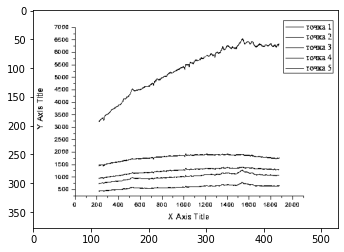

In [3]:
# сравнение пикселя с пороговым значением и замена цвета
for y in range(im.size[1]):
    for x in range(im.size[0]):
        if sum(im.getpixel((x, y))) < 128:
            im.putpixel((x, y), col_black)
        else:
            im.putpixel((x, y), col_white)

plt.imshow(im)
plt.show()

In [4]:
#массивы чёрных пикселей x, y, xy
black_pixels_X = []
black_pixels_Y = []
black_pixels = []
for y in range(im.size[1]):
    for x in range(im.size[0]):
        if im.getpixel((x, y)) == col_black:
            black_pixels_X.append(x)
            black_pixels_Y.append(y)
            black_pixels.append({'x': x, 'y': y})

In [5]:
#функция нахождения постоянного значения x на оY и наоборот y на oX
def findAxiosCoordXorY(array, coordParam):
    black_pixels_X_with_count = [{coordParam: i, 'count': array.count((i))} for i in array]
    black_pixels_X_with_count_sort_by_count = sorted(black_pixels_X_with_count, key=lambda x: x['count'], reverse=True)
    coordAxiosXorY = black_pixels_X_with_count_sort_by_count[0][coordParam]
    return coordAxiosXorY

axios_y_const_x = findAxiosCoordXorY(black_pixels_X, 'x')
axios_x_const_y = findAxiosCoordXorY(black_pixels_Y, 'y')

In [6]:
#координаты оY
axiosYCoords = []
for pixel in black_pixels:
    if axios_y_const_x == pixel['x']:
        axiosYCoords.append({'x': pixel['x'], 'y': pixel['y']})

In [7]:
#координаты оX
axiosXCoords = []
for pixel in black_pixels:
    if axios_x_const_y == pixel['y']:
        axiosXCoords.append({'x': pixel['x'], 'y': pixel['y']})

In [8]:
#удаляем лишние пиксили в столбце/строке в котором есть координаты оY/oX
def removeUnnecessaryPixels(array, coordParam):
    tempArray = []
    for i in range(len(array)):
        if array[i][coordParam] == array[i - 1][coordParam] + 1 or i == 0:
            tempArray.append({'x': array[i]['x'], 'y': array[i]['y']})
        else:
            break
    return tempArray

axiosYCoords = removeUnnecessaryPixels(axiosYCoords, 'y')
axiosXCoords = removeUnnecessaryPixels(axiosXCoords, 'x')

print('axiosYCoords: ', axiosYCoords)
print('axiosXCoords: ', axiosXCoords)

axiosYCoords:  [{'x': 73, 'y': 30}, {'x': 73, 'y': 31}, {'x': 73, 'y': 32}, {'x': 73, 'y': 33}, {'x': 73, 'y': 34}, {'x': 73, 'y': 35}, {'x': 73, 'y': 36}, {'x': 73, 'y': 37}, {'x': 73, 'y': 38}, {'x': 73, 'y': 39}, {'x': 73, 'y': 40}, {'x': 73, 'y': 41}, {'x': 73, 'y': 42}, {'x': 73, 'y': 43}, {'x': 73, 'y': 44}, {'x': 73, 'y': 45}, {'x': 73, 'y': 46}, {'x': 73, 'y': 47}, {'x': 73, 'y': 48}, {'x': 73, 'y': 49}, {'x': 73, 'y': 50}, {'x': 73, 'y': 51}, {'x': 73, 'y': 52}, {'x': 73, 'y': 53}, {'x': 73, 'y': 54}, {'x': 73, 'y': 55}, {'x': 73, 'y': 56}, {'x': 73, 'y': 57}, {'x': 73, 'y': 58}, {'x': 73, 'y': 59}, {'x': 73, 'y': 60}, {'x': 73, 'y': 61}, {'x': 73, 'y': 62}, {'x': 73, 'y': 63}, {'x': 73, 'y': 64}, {'x': 73, 'y': 65}, {'x': 73, 'y': 66}, {'x': 73, 'y': 67}, {'x': 73, 'y': 68}, {'x': 73, 'y': 69}, {'x': 73, 'y': 70}, {'x': 73, 'y': 71}, {'x': 73, 'y': 72}, {'x': 73, 'y': 73}, {'x': 73, 'y': 74}, {'x': 73, 'y': 75}, {'x': 73, 'y': 76}, {'x': 73, 'y': 77}, {'x': 73, 'y': 78}, {'x'

In [9]:
#находим пересечение осей oY и oX
beginning_of_coord = 0
for axiosYCoord in axiosYCoords:
    for axiosXcoord in axiosXCoords:
        if axiosYCoord['x'] == axiosXcoord['x'] and axiosYCoord['y'] == axiosXcoord['y']:
            beginning_of_coord = axiosXcoord
            break

print('beginning_of_coord: ', beginning_of_coord)

beginning_of_coord:  {'x': 73, 'y': 322}


In [10]:
#находим большой последний штрих на oY и oX
def findLastStroke(array, axios):
    strokeArray = []
    thresholdPx = 4
    if axios == 'x':
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x, y + thresholdPx)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        return [strokeArray[len(strokeArray) - 2], strokeArray[len(strokeArray) - 1]]
    else:
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x - thresholdPx, y)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        return strokeArray[0]

prevLastStrokeX, lastStrokeX = findLastStroke(axiosXCoords, 'x')
lastStrokeY = findLastStroke(axiosYCoords, 'y')
print('lastStrokeX: ', lastStrokeX)
print('lastStrokeY', lastStrokeY)

lastStrokeX:  {'x': 450, 'y': 322}
lastStrokeY {'x': 73, 'y': 30}


In [11]:
#функция распознания максимальных значений функции с картинки
def recognizeText(img):
    im_tesseract = cv2.resize(img, None, fx=6, fy=6)

    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    config = r'--oem 3 --psm 6 outputbase digits'
    string = pytesseract.image_to_string(im_tesseract, config=config)
    text = int(string.split()[0]) if len(string) > 4 else int(string)
    return text

In [12]:
#вырезаем максимальное значение функции oY/oX с картинки
im_crop1Y = im.crop((lastStrokeY['x'] - 39, lastStrokeY['y'] - 7, lastStrokeY['x'] - 9, lastStrokeY['y'] + 5))
im_crop1Y.save('textY.png')
im_crop1X = im.crop((lastStrokeX['x'] - 16, lastStrokeX['y'] + 9, lastStrokeX['x'] + 13, lastStrokeX['y'] + 21))
im_crop1X.save('textX.png')

axiosMax1 = recognizeText(cv2.imread("textY.png", cv2.IMREAD_GRAYSCALE))
axiosMax2 = recognizeText(cv2.imread("textX.png", cv2.IMREAD_GRAYSCALE))

In [13]:
#проверяем что больше, то и присваиваем axiosYmax меньше axiosXmax
axiosYmax = 0
axiosXmax = 0
if(axiosMax1 > axiosMax2):
    axiosYmax = axiosMax1
    axiosXmax = axiosMax2
else:
    axiosYmax = axiosMax2
    axiosXmax = axiosMax1

print('axiosYmax:', axiosYmax)
print('axiosXmax:', axiosXmax)

axiosYmax: 7000
axiosXmax: 2000


In [14]:
#сколько 1px занимает значений функции
img_1px_equel_func_valueX = axiosXmax / (lastStrokeX['x'] - beginning_of_coord['x'])
img_1px_equel_func_valueY = axiosYmax / (beginning_of_coord['y'] - lastStrokeY['y'])

print('img_1px_equel_func_valueX: ', img_1px_equel_func_valueX)
print('img_1px_equel_func_valueY: ', img_1px_equel_func_valueY)

img_1px_equel_func_valueX:  5.305039787798409
img_1px_equel_func_valueY:  23.972602739726028


In [15]:
print('prevLastStrokeX: ', prevLastStrokeX)
lastSmallStrokeX = {'x': int(lastStrokeX['x'] - (lastStrokeX['x'] - prevLastStrokeX['x']) / 2), 'y': lastStrokeX['y']}
print('lastSmallStrokeX: ', lastSmallStrokeX)
#вырежаем график
cropIm = im.crop((lastStrokeY['x'] + 1, lastStrokeY['y'], lastSmallStrokeX['x'], lastSmallStrokeX['y']))
cropIm.save("cropIm.jpg")

prevLastStrokeX:  {'x': 412, 'y': 322}
lastSmallStrokeX:  {'x': 431, 'y': 322}


In [16]:
#проверяем что больше, то и присваиваем axiosYmax меньше axiosXmax
axiosYmax = 0
axiosXmax = 0
if(axiosMax1 > axiosMax2):
    axiosYmax = axiosMax1
    axiosXmax = axiosMax2
else:
    axiosYmax = axiosMax2
    axiosXmax = axiosMax1

print('axiosYmax:', axiosYmax)
print('axiosXmax:', axiosXmax)

axiosYmax: 7000
axiosXmax: 2000


In [17]:
#находим точки старта каждого графика
point_start_array = []
prev_y = 0
for x in range(cropIm.size[0]):
    for y in range(cropIm.size[1]):
        if cropIm.getpixel((x, y)) == col_black and cropIm.getpixel((x, y - 1)) == col_white:
            if y > prev_y:
                point_start_array.append({'x': x, 'y': y})
                # point_start_array.append({'x': x + lastStrokeY['x'] + 1, 'y': y + lastStrokeY['y']})
                prev_y = y
            else:
                break
            # if len(point_start_array) > 4:
            #     break
            # else:
            #     point_start_array.append({'x': x, 'y': y})

number_graphs = len(point_start_array)

print('point_start_array: ', point_start_array)
print('graphs: ', number_graphs)

point_start_array:  [{'x': 40, 'y': 162}, {'x': 40, 'y': 238}, {'x': 40, 'y': 261}, {'x': 40, 'y': 270}, {'x': 40, 'y': 283}]
graphs:  5


In [18]:
#Костыль/интерполяция
cropIm.putpixel((173, 259), col_black)
#Костыль/интерполяция

In [19]:
#Все чёрные пиксели для каждого графика
black_pixels_graphs = []
# k = 0
for x in range(cropIm.size[0]):
    for y in range(cropIm.size[1]):
        if cropIm.getpixel((x, y)) == col_black and cropIm.getpixel((x, y - 1)) == col_white:
            black_pixels_graphs.append({'x': x, 'y': y})
            # k = k + 1

print(black_pixels_graphs)

[{'x': 40, 'y': 162}, {'x': 40, 'y': 238}, {'x': 40, 'y': 261}, {'x': 40, 'y': 270}, {'x': 40, 'y': 283}, {'x': 41, 'y': 161}, {'x': 41, 'y': 238}, {'x': 41, 'y': 261}, {'x': 41, 'y': 270}, {'x': 41, 'y': 283}, {'x': 42, 'y': 160}, {'x': 42, 'y': 238}, {'x': 42, 'y': 261}, {'x': 42, 'y': 270}, {'x': 42, 'y': 283}, {'x': 43, 'y': 159}, {'x': 43, 'y': 238}, {'x': 43, 'y': 260}, {'x': 43, 'y': 270}, {'x': 43, 'y': 283}, {'x': 44, 'y': 158}, {'x': 44, 'y': 238}, {'x': 44, 'y': 260}, {'x': 44, 'y': 270}, {'x': 44, 'y': 283}, {'x': 45, 'y': 157}, {'x': 45, 'y': 238}, {'x': 45, 'y': 260}, {'x': 45, 'y': 269}, {'x': 45, 'y': 283}, {'x': 46, 'y': 157}, {'x': 46, 'y': 238}, {'x': 46, 'y': 260}, {'x': 46, 'y': 269}, {'x': 46, 'y': 283}, {'x': 47, 'y': 156}, {'x': 47, 'y': 238}, {'x': 47, 'y': 260}, {'x': 47, 'y': 269}, {'x': 47, 'y': 283}, {'x': 48, 'y': 159}, {'x': 48, 'y': 238}, {'x': 48, 'y': 261}, {'x': 48, 'y': 270}, {'x': 48, 'y': 283}, {'x': 49, 'y': 155}, {'x': 49, 'y': 238}, {'x': 49, 'y

In [20]:
#добавляем пиксили для каждого графика
def addPixelToArray(arr, n, step):
    array = []
    for i in range(n, len(arr), step):
        array.append(arr[i])
    return array

arr1 = addPixelToArray(black_pixels_graphs, 0, len(point_start_array))
arr2 = addPixelToArray(black_pixels_graphs, 1, len(point_start_array))
arr3 = addPixelToArray(black_pixels_graphs, 2, len(point_start_array))
arr4 = addPixelToArray(black_pixels_graphs, 3, len(point_start_array))
arr5 = addPixelToArray(black_pixels_graphs, 4, len(point_start_array))

print('arrays: ')
print(len(arr1))
arr1.pop(len(arr1) - 1)
print(len(arr2))
arr2.pop(len(arr2) - 1)
print(len(arr3))
print(len(arr4))
print(len(arr5))

arrays: 
314
314
313
313
313


widths:  [ 5.   5.   2.   2.   2.   2.   6.   4.   4.  31.5]


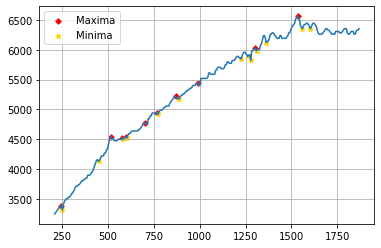

peaks:  [{'x': 249.3368700265252, 'y': 3391.459074733096}, {'x': 519.893899204244, 'y': 4548.042704626334}, {'x': 578.2493368700266, 'y': 4524.911032028469}, {'x': 599.4694960212202, 'y': 4548.042704626334}, {'x': 705.5702917771883, 'y': 4779.359430604982}, {'x': 769.2307692307693, 'y': 4941.281138790036}, {'x': 870.026525198939, 'y': 5218.861209964412}, {'x': 992.0424403183024, 'y': 5450.17793594306}, {'x': 1299.73474801061, 'y': 6028.46975088968}, {'x': 1533.15649867374, 'y': 6560.498220640569}]
lengthArray:  10
widths:  [  2.   2.   2.   2.   2. 221.   2.   2.   2.]


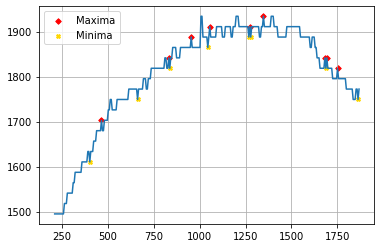

peaks:  [{'x': 466.84350132625997, 'y': 1702.8469750889678}, {'x': 832.8912466843501, 'y': 1841.6370106761565}, {'x': 954.9071618037135, 'y': 1887.900355871886}, {'x': 1055.7029177718832, 'y': 1911.032028469751}, {'x': 1273.209549071618, 'y': 1911.032028469751}, {'x': 1347.4801061007959, 'y': 1934.1637010676156}, {'x': 1681.6976127320954, 'y': 1841.6370106761565}, {'x': 1692.3076923076924, 'y': 1841.6370106761565}, {'x': 1750.6631299734747, 'y': 1818.5053380782917}]
lengthArray:  9
widths:  [  2.   2.   2.   2.   2.   2.   2.   2. 159.   2. 159.   2.]


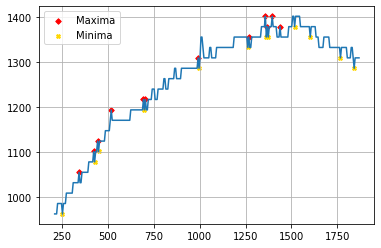

peaks:  [{'x': 344.82758620689657, 'y': 1055.1601423487546}, {'x': 424.40318302387266, 'y': 1101.423487544484}, {'x': 445.62334217506634, 'y': 1124.5551601423488}, {'x': 519.893899204244, 'y': 1193.950177935943}, {'x': 694.9602122015915, 'y': 1217.081850533808}, {'x': 705.5702917771883, 'y': 1217.081850533808}, {'x': 992.0424403183024, 'y': 1309.6085409252669}, {'x': 1267.9045092838196, 'y': 1355.8718861209964}, {'x': 1358.0901856763926, 'y': 1402.1352313167258}, {'x': 1368.7002652519893, 'y': 1379.0035587188613}, {'x': 1395.2254641909815, 'y': 1402.1352313167258}, {'x': 1437.6657824933686, 'y': 1379.0035587188613}]
lengthArray:  12
widths:  [2.         2.66666667 2.        ]


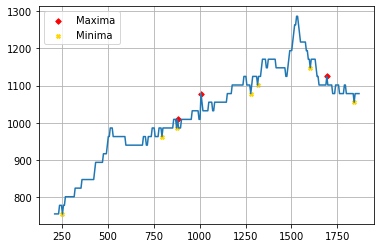

peaks:  [{'x': 880.6366047745358, 'y': 1008.8967971530249}, {'x': 1007.9575596816976, 'y': 1078.291814946619}, {'x': 1692.3076923076924, 'y': 1124.5551601423488}]
lengthArray:  3
widths:  [ 2.  2.  2.  2. 83.  2.]


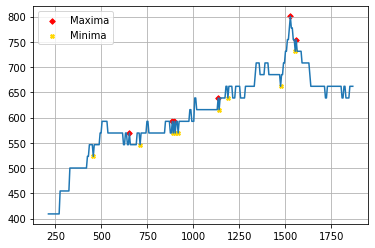

peaks:  [{'x': 652.5198938992042, 'y': 569.3950177935943}, {'x': 885.9416445623342, 'y': 592.526690391459}, {'x': 896.551724137931, 'y': 592.526690391459}, {'x': 1135.2785145888595, 'y': 638.7900355871886}, {'x': 1527.8514588859416, 'y': 800.711743772242}, {'x': 1559.681697612732, 'y': 754.4483985765124}]
lengthArray:  6


In [21]:
#--- refactoring ---#
def showPeaks(array_black):
    arrayX = []
    arrayY = []
    for pixel in array_black:
        arrayX.append(pixel['x'])
        arrayY.append(pixel['y'])
        # arrayY.append(291 + 1 - pixel['y'])

    # for x in arrayX:
    #     x = x * img_1px_equel_func_valueX
    # for y in arrayY:
    #     y = y * img_1px_equel_func_valueY

    for i,x in enumerate(arrayX):
        arrayX[i] = x * img_1px_equel_func_valueX
    for i,y in enumerate(arrayY):
        # arrayY[i] = (292 - y - 11) * ((7000 - 500) / (311 - 30)) + 500
        arrayY[i] = ((292 - y) * (500 / 11)) if 292 - 11 < arrayY[i]  else (292 - y - 11) * ((7000 - 500) / (292 - 11)) + 500

    # arrayY = np.interp(np.array(range(2000)), arrayX, arrayY)
    # arrayX = np.array(range(2000))

    # arrayX = list(map(lambda x: x * img_1px_equel_func_valueX, arrayX))
    # arrayY = list(map(lambda y: y * img_1px_equel_func_valueY, arrayY))

# print(array_black)

    # defining the x and y arrays
    x = np.array(arrayX)
    y = np.array(arrayY)

    # Find peaks
    peaks = find_peaks(y, height=1, threshold=1, distance=1)
    height = peaks[1]['peak_heights']  # list of the heights of the peaks
    
    widths = peak_widths(y, peaks[0], rel_height=1)
    print('widths: ', widths[0])
    
    peak_pos = x[peaks[0]]  # list of the peaks positions
    # Finding the minima
    y2 = y * -1
    minima = find_peaks(y2, threshold=1, distance=1)
    min_pos = x[minima[0]]  # list containing the positions of the minima
    min_height = y2[minima[0]]  # list containing the height of the minima
    # Plotting
    fig = plt.figure()
    ax = fig.subplots()
#     plt.ylim([0, 7000])
#     plt.xlim([0, 2000])
    ax.plot(x, y)
    ax.scatter(peak_pos, height, color='r', s=15, marker='D', label='Maxima')
    ax.scatter(min_pos, min_height * -1, color='gold', s=15, marker='X', label='Minima')
    ax.legend()
    ax.grid()
    plt.show()

    arrayCoordPeaks = []
    for i in peaks[0]:
        arrayCoordPeaks.append({'x': arrayX[i], 'y': arrayY[i]})
        # print('elem: ', arrayX[i])

    print('peaks: ', arrayCoordPeaks)
    print('lengthArray: ', len(arrayCoordPeaks))


showPeaks(arr1)
showPeaks(arr2)
showPeaks(arr3)
showPeaks(arr4)
showPeaks(arr5)

In [228]:
from PIL import Image
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks, peak_widths
from itertools import groupby

In [229]:
# img_gray = cv2.imread("photo2.bmp", cv2.IMREAD_GRAYSCALE)
# img_binary = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)[1]
# cv2.imwrite('save.jpg', img_binary)
#
# im = Image.open("save.jpg")
# im = im.convert('RGB')

im = Image.open("2.bmp")
im = im.convert('RGB')

col_black = (0, 0, 0)
col_white = (255, 255, 255)

# #сравнение пикселя с пороговым значением и замена цвета
# for y in range(im.size[1]):
#     for x in range(im.size[0]):
#         if sum(im.getpixel((x, y))) < 128:
#             im.putpixel((x, y), col_black)
#         else:
#             im.putpixel((x, y), col_white)

plt.imshow(im)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '2.bmp'

In [ ]:
#массивы чёрных пикселей x, y, xy
black_pixels_X = []
black_pixels_Y = []
black_pixels = []
for y in range(im.size[1]):
    for x in range(im.size[0]):
        if im.getpixel((x, y)) == col_black:
            black_pixels_X.append(x)
            black_pixels_Y.append(y)
            black_pixels.append({'x': x, 'y': y})

In [ ]:
#функция нахождения постоянного значения x на оY и наоборот y на oX
def findAxiosCoordXorY(array, coordParam):
    black_pixels_X_with_count = [{coordParam: i, 'count': array.count((i))} for i in array]
    black_pixels_X_with_count_sort_by_count = sorted(black_pixels_X_with_count, key=lambda x: x['count'], reverse=True)
    withoutDuplicates = [el for el, _ in groupby(black_pixels_X_with_count_sort_by_count)]
    coordAxiosXorY = withoutDuplicates[0][coordParam]
    # print('withoutDuplicates: ', withoutDuplicates)

    if coordParam == 'x' and withoutDuplicates[0]['count'] - withoutDuplicates[1]['count'] <= 100:
        vertLineX = withoutDuplicates[1]['x']
        # print('vertLineX: ', vertLineX)

        vertLineCoords = []
        for pixel in black_pixels:
            if vertLineX == pixel['x']:
                vertLineCoords.append({'x': pixel['x'], 'y': pixel['y']})
        print('vertLineCoords: ', vertLineCoords)

        for x in range(im.size[0]):
            for y in range(im.size[1]):
                if x == vertLineX and (y >= vertLineCoords[0]['y'] or y <= vertLineCoords[len(vertLineCoords) - 1]['y']):
                    im.putpixel((x, y), col_white)

    return coordAxiosXorY

axios_y_const_x = findAxiosCoordXorY(black_pixels_X, 'x')
axios_x_const_y = findAxiosCoordXorY(black_pixels_Y, 'y')

In [230]:
#координаты оY
axiosYCoords = []
for pixel in black_pixels:
    if axios_y_const_x == pixel['x']:
        axiosYCoords.append({'x': pixel['x'], 'y': pixel['y']})

#координаты оX
axiosXCoords = []
for pixel in black_pixels:
    if axios_x_const_y == pixel['y']:
        axiosXCoords.append({'x': pixel['x'], 'y': pixel['y']})

NameError: name 'black_pixels' is not defined

In [231]:
#удаляем лишние пиксили в столбце/строке в котором есть координаты оY/oX
def removeUnnecessaryPixels(array, coordParam):
    tempArray = []
    for i in range(len(array)):
        if array[i][coordParam] == array[i - 1][coordParam] + 1 or i == 0:
            tempArray.append({'x': array[i]['x'], 'y': array[i]['y']})
        else:
            break
    return tempArray

axiosYCoords = removeUnnecessaryPixels(axiosYCoords, 'y')
axiosXCoords = removeUnnecessaryPixels(axiosXCoords, 'x')

print('axiosYCoords: ', axiosYCoords)
print('axiosXCoords: ', axiosXCoords)

NameError: name 'axiosXCoords' is not defined

In [232]:
#находим пересечение осей oY и oX
beginning_of_coord = 0
for axiosYCoord in axiosYCoords:
    for axiosXcoord in axiosXCoords:
        if axiosYCoord['x'] == axiosXcoord['x'] and axiosYCoord['y'] == axiosXcoord['y']:
            beginning_of_coord = axiosXcoord
            break

print('beginning_of_coord: ', beginning_of_coord)

beginning_of_coord:  0


In [233]:
#находим большой последний штрих на oY и oX
thresholdX = thresholdStroke('x')
thresholdY = thresholdStroke('y')

def findLastStroke(array, axios):
    strokeArray = []

    if axios == 'x':
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x, y + thresholdX)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        print('allX: ', strokeArray)
        print('strokeX: ', [strokeArray[0], strokeArray[len(strokeArray) - 2], strokeArray[len(strokeArray) - 1]])
        return [strokeArray[0], strokeArray[len(strokeArray) - 2], strokeArray[len(strokeArray) - 1]]
    else:
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x - thresholdY, y)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        print('strokeY: ', [strokeArray[len(strokeArray) - 1], strokeArray[1], strokeArray[0]])
        print('allY: ', strokeArray)

        return [strokeArray[len(strokeArray) - 1], strokeArray[1], strokeArray[0]]

firstStrokeX, secondLastStrokeX, lastStrokeX = findLastStroke(axiosXCoords, 'x')
firstStrokeY, secondLastStrokeY, lastStrokeY = findLastStroke(axiosYCoords, 'y')
print('firstStrokeX: ', firstStrokeX, 'secondLastStrokeX: ', secondLastStrokeX, 'lastStrokeX: ', lastStrokeX)
print('firstStrokeY: ', firstStrokeY, 'secondLastStrokeY: ', secondLastStrokeY, 'lastStrokeY: ', lastStrokeY)

TypeError: thresholdStroke() missing 6 required positional arguments: 'im', 'axis_x_const_y', 'axisXCoords', 'col_black', 'axis_y_const_x', and 'axisYCoords'

In [234]:
#функция распознания максимальных значений функции с картинки
def recognizeText(img):
    im_tesseract = cv2.resize(img, None, fx=9, fy=9)

    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    config = r'--oem 3 --psm 6 outputbase digits'
    string = pytesseract.image_to_string(im_tesseract, config=config)
    text = int(string.split()[0]) if len(string) > 4 else int(string)
    return text

In [235]:
#вырезаем максимальное значение функции oY/oX с картинки
diffStrokeY = int(abs((lastStrokeY['y'] - secondLastStrokeY['y']) / 2))
im_cropMaxY = im.crop((lastStrokeY['x'] - thresholdY - 40, lastStrokeY['y'] - diffStrokeY,
                     lastStrokeY['x'] - thresholdY, lastStrokeY['y'] + diffStrokeY))
im_cropMaxY.save('img/cropMaxY.png')

diffStrokeX = int(abs((lastStrokeX['x'] - secondLastStrokeX['x']) / 2))
im_cropMaxX = im.crop((lastStrokeX['x'] - diffStrokeX, lastStrokeX['y'] + thresholdX + 1,
                     lastStrokeX['x'] + diffStrokeX, lastStrokeX['y'] + 25))
im_cropMaxX.save('img/cropMaxX.png')

maxValueY = recognizeText(cv2.imread("img/cropMaxY.png", cv2.IMREAD_GRAYSCALE))
maxValueX = recognizeText(cv2.imread("img/cropMaxX.png", cv2.IMREAD_GRAYSCALE))

print('maxValueY: ', maxValueY)
print('maxValueX: ', maxValueX)

NameError: name 'lastStrokeY' is not defined

In [58]:
from PIL import Image
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from itertools import groupby
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

In [59]:
# ------------ФУНКЦИИ------------

# функция нахождения постоянного значения x оY и y oX и удаление чёрной вертикальной линии
def findAxisConstValue(array, coordParam, black_pixels, im, col_white):
    black_pixels_X_with_count = [{coordParam: i, 'count': array.count((i))} for i in array]
    black_pixels_X_with_count_sort_by_count = sorted(black_pixels_X_with_count, key=lambda x: x['count'], reverse=True)
    withoutDuplicates = [el for el, _ in groupby(black_pixels_X_with_count_sort_by_count)]
    axisConstValue = withoutDuplicates[0][coordParam]

    if coordParam == 'x' and withoutDuplicates[0]['count'] - withoutDuplicates[1]['count'] <= 100:
        vertLineX = withoutDuplicates[1]['x']

        vertLineCoords = []
        for pixel in black_pixels:
            if vertLineX == pixel['x']:
                vertLineCoords.append({'x': pixel['x'], 'y': pixel['y']})
        print('vertLineCoords: ', vertLineCoords)

        for x in range(im.size[0]):
            for y in range(im.size[1]):
                if x == vertLineX and (
                        y >= vertLineCoords[0]['y'] or y <= vertLineCoords[len(vertLineCoords) - 1]['y']):
                    im.putpixel((x, y), col_white)

    return axisConstValue

# функция удаления лишних пикселей в столбце и строке в котором есть координаты оY и oX
def removeUnnecessaryPixels(array, coordParam):
    tempArray = []
    for i in range(len(array)):
        if array[i][coordParam] == array[i - 1][coordParam] + 1 or i == 0:
            tempArray.append({'x': array[i]['x'], 'y': array[i]['y']})
        else:
            break
    return tempArray

# функция нахождения порога у мал и бол штрихов на оX и oY
def thresholdStroke(axis, im, axis_x_const_y, axisXCoords, col_black, axis_y_const_x, axisYCoords):
    threshols = []
    if axis == 'x':
        for x in range(im.size[0]):
            k = 0
            for y in range(im.size[1]):
                if y >= axis_x_const_y and x >= axisXCoords[0]['x'] and x <= axisXCoords[len(axisXCoords) - 1]['x'] and \
                        im.getpixel((x, axis_x_const_y + k + 1)) == col_black:
                    k = k + 1
                if y == im.size[1] - 1 and k != 0:
                    threshols.append(k)
        threshols = list(set(threshols))
        return {'smallThresholsX': threshols[0], 'bigThresholsX': threshols[1]}
    else:
        for y in range(im.size[1]):
            k = 0
            for x in reversed(range(im.size[0])):
                if x <= axis_y_const_x and y >= axisYCoords[0]['y'] and y <= axisYCoords[len(axisYCoords) - 1]['y'] and \
                        im.getpixel((axis_y_const_x - k - 1, y)) == col_black:
                    k = k + 1
                if x == 0 and k != 0:
                    threshols.append(k)
        threshols = list(set(threshols))
        return {'smallThresholsY': threshols[0], 'bigThresholsY': threshols[1]}

# функция нахождение штрихов по порогу на оX и oY
def findStrokes(array, axis, threshold, im, col_black):
    strokeArray = []

    if axis == 'x':
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x, y + threshold)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        return [strokeArray[0], strokeArray[len(strokeArray) - 2], strokeArray[len(strokeArray) - 1]]
    else:
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                if im.getpixel((x, y)) == col_black:
                    elem = list(filter(lambda el: el['x'] == x and el['y'] == y, array))
                    if len(elem) != 0 and im.getpixel((x - threshold, y)) == col_black:
                        strokeArray.append({'x': x, 'y': y})
        return [strokeArray[len(strokeArray) - 1], strokeArray[1], strokeArray[0]]

# функция распознания значений интенсивности и волнового числа с картинки
def recognizeValue(img):
    im_tesseract = cv2.resize(img, None, fx=9, fy=9)
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    config = r'--oem 3 --psm 6 outputbase digits'
    string = pytesseract.image_to_string(im_tesseract, config=config)
    value = int(string.split()[0]) if len(string) > 4 else int(string)
    return value

# функция нахождения пикселей для каждой точки образца
def findPixelsForPoint(color, cropIm):
    pixelsArray = []
    arrayX = []
    arrayY = []
    for x in range(cropIm.size[0]):
        k = 0
        for y in range(cropIm.size[1]):
            if k == 1:
                k == 0
                break
            if cropIm.getpixel((x, y)) == color:
                k = k + 1
                pixelsArray.append({'x': x, 'y': y})
                arrayX.append(x)
                arrayY.append(y)

    listX = list(range(pixelsArray[0]['x'], pixelsArray[len(pixelsArray) - 1]['x'] + 1))
    interpArrayY = np.interp(listX, arrayX, arrayY)

    newArray = []
    for i, y in enumerate(interpArrayY):
        newArray.append({'x': listX[i], 'y': y})

    return newArray

# функция получения и визуализации пиков
def getPeaks(pointArray, img_1px_equel_func_valueX, firstBigStrokeY, beginning_of_coord, cropIm, 
             img_1px_equel_func_valueY, minValueY):
    arrayX = []
    arrayY = []
    for pixel in pointArray:
        arrayX.append(pixel['x'])
        arrayY.append(pixel['y'])

    intensityArray = []
    waveNumberArray = []
    for i, x in enumerate(arrayX):
        waveNumberArray.append(x * img_1px_equel_func_valueX)
    for i, y in enumerate(arrayY):
        if firstBigStrokeY['y'] == beginning_of_coord['y']:
            intensityArray.append((cropIm.size[1] - y) * img_1px_equel_func_valueY + minValueY)
        else:
            diffStrokeY = beginning_of_coord['y'] - firstBigStrokeY['y']

            if y < firstBigStrokeY['y']:
                intensityArray.append((firstBigStrokeY['y'] - y) * img_1px_equel_func_valueY + minValueY)
            else:
                intensityArray.append(((cropIm.size[1] - y) * ((minValueY - 0) / diffStrokeY)))

    intensityArray = np.array(intensityArray)
    waveNumberArray = np.array(waveNumberArray)

    peaks = find_peaks(intensityArray, height=1, threshold=1, distance=1)
    height = peaks[1]['peak_heights']
    peak_pos = waveNumberArray[peaks[0]]

    plt.plot(waveNumberArray, intensityArray)
    plt.scatter(peak_pos, height, color='r', s=15, marker='D', label='Peak')
    plt.legend()
    plt.grid()
    plt.xlabel('Wave number', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.show()

    peaksArray = []
    for i in peaks[0]:
        peaksArray.append({'waveNumber': waveNumberArray[i], 'intensity': intensityArray[i]})

    return peaksArray

# функция нахождения уникальных пиков
def setUniqPeaks(currPeaksArray, peaksArrays):
    for peaksArray in peaksArrays:
        for currPeak in currPeaksArray:
            for peak in peaksArray:
                if currPeak['waveNumber'] == peak['waveNumber']:
                    currPeak['noUniq'] = True
                    peak['noUniq'] = True

    return currPeaksArray

# функция записи в Microsoft Excel значений пиков
def writeToExcell(array, row, pointNumber, font, alignment):
    ws.merge_cells('A' + str(row + 1) + ':C' + str(row + 1))
    ws.cell(column=1, row=row + 1).value = 'Точка № ' + str(pointNumber)
    ws.cell(column=1, row=row + 1).font = font
    ws.cell(column=1, row=row + 1).alignment = alignment

    ws.cell(column=1, row=row + 2).value = 'waveNumber'
    ws.cell(column=1, row=row + 2).font = font
    ws.cell(column=1, row=row + 2).alignment = alignment

    ws.cell(column=2, row=row + 2).value = 'intensity'
    ws.cell(column=2, row=row + 2).font = font
    ws.cell(column=2, row=row + 2).alignment = alignment

    ws.cell(column=3, row=row + 2).value = 'UNIQ'
    ws.cell(column=3, row=row + 2).font = font
    ws.cell(column=3, row=row + 2).alignment = alignment

    for i in range(len(array)):
        ws.cell(column=1, row=row + 3).value = array[i]['waveNumber']
        ws.cell(column=2, row=row + 3).value = array[i]['intensity']
        ws.cell(column=3, row=row + 3).value = '-' if 'noUniq' in array[i] else '+'
        row = row + 1

    pointNumber = pointNumber + 1
    row = row + 2
    return row, pointNumber

# ------------ФУНКЦИИ------------

In [60]:
# функция обработки изображения и получения данных
def getResultsFromImg(imgPath, sampleNumber, row):
    im = Image.open(imgPath)
    im = im.convert('RGB')

    col_black = (0, 0, 0)
    col_white = (255, 255, 255)

    # массивы чёрных пикселей x, y, xy
    black_pixels_X = []
    black_pixels_Y = []
    black_pixels = []
    for y in range(im.size[1]):
        for x in range(im.size[0]):
            if im.getpixel((x, y)) == col_black:
                black_pixels_X.append(x)
                black_pixels_Y.append(y)
                black_pixels.append({'x': x, 'y': y})

    # нахождения постоянного значения x оY и y oX и удаление чёрной вертикальной линии
    axis_y_const_x = findAxisConstValue(black_pixels_X, 'x', black_pixels, im, col_white)
    axis_x_const_y = findAxisConstValue(black_pixels_Y, 'y', black_pixels, im, col_white)

    # нахождение всех чёрных пикселей в столбце в котором находится ось Y
    axisYCoords = []
    for pixel in black_pixels:
        if axis_y_const_x == pixel['x']:
            axisYCoords.append({'x': pixel['x'], 'y': pixel['y']})

    # нахождение всех чёрных пикселей в столбце в котором находится ось X
    axisXCoords = []
    for pixel in black_pixels:
        if axis_x_const_y == pixel['y']:
            axisXCoords.append({'x': pixel['x'], 'y': pixel['y']})

    # удаления лишних пикселей в столбце и строке в котором есть координаты оY и oX
    axisYCoords = removeUnnecessaryPixels(axisYCoords, 'y')
    axisXCoords = removeUnnecessaryPixels(axisXCoords, 'x')

    print('axisYCoords: ', axisYCoords)
    print('axisXCoords: ', axisXCoords)

    # находим начало координат(пересечение oY и oX)
    beginning_of_coord = 0
    for axisYCoord in axisYCoords:
        for axisXcoord in axisXCoords:
            if axisYCoord['x'] == axisXcoord['x'] and axisYCoord['y'] == axisXcoord['y']:
                beginning_of_coord = axisXcoord
                break

    print('beginning_of_coord: ', beginning_of_coord)

    # нахождение порога у мал и бол штрихов на оX и oY
    thresholdsX = thresholdStroke('x', im, axis_x_const_y, axisXCoords, col_black, axis_y_const_x, axisYCoords)
    thresholdsY = thresholdStroke('y', im, axis_x_const_y, axisXCoords, col_black, axis_y_const_x, axisYCoords)

    print('thresholdX: ', thresholdsX)
    print('thresholdY: ', thresholdsY)

    # нахождение штрихов по порогу на оX и oY
    firstBigStrokeX, secondLastBigStrokeX, lastBigStrokeX = findStrokes(axisXCoords, 'x', thresholdsX['bigThresholsX'], 
                                                        im, col_black)
    firstBigStrokeY, secondLastBigStrokeY, lastBigStrokeY = findStrokes(axisYCoords, 'y', thresholdsY['bigThresholsY'], 
                                                        im, col_black)
    _, secondSmallStrokeX, _ = findStrokes(axisXCoords, 'x', thresholdsX['smallThresholsX'], im, col_black)

    print('firstBigStrokeX: ', firstBigStrokeX, 'lastBigStrokeX: ', lastBigStrokeX)
    print('firstBigStrokeY: ', firstBigStrokeY, 'lastBigStrokeY: ', lastBigStrokeY)
    print('secondSmallStrokeX: ', secondSmallStrokeX)

    # распознование максимального значения интенсивности на oY и волнового числа на oX с картинки
    diffBigStrokeY = int(abs((lastBigStrokeY['y'] - secondLastBigStrokeY['y']) / 2))
    im_cropMaxY = im.crop(
        (lastBigStrokeY['x'] - thresholdsX['bigThresholsX'] - 40, lastBigStrokeY['y'] - diffBigStrokeY,
         lastBigStrokeY['x'] - thresholdsY['bigThresholsY'], lastBigStrokeY['y'] + diffBigStrokeY))
    im_cropMaxY.save('img/crops/cropMaxY.png')

    diffBigStrokeX = int(abs((lastBigStrokeX['x'] - secondLastBigStrokeX['x']) / 2))
    im_cropMaxX = im.crop((lastBigStrokeX['x'] - diffBigStrokeX, lastBigStrokeX['y'] + thresholdsX['bigThresholsX'] + 1,
                           lastBigStrokeX['x'] + diffBigStrokeX, lastBigStrokeX['y'] + 25))
    im_cropMaxX.save('img/crops/cropMaxX.png')

    maxValueY = recognizeValue(cv2.imread("img/crops/cropMaxY.png", cv2.IMREAD_GRAYSCALE))
    maxValueX = recognizeValue(cv2.imread("img/crops/cropMaxX.png", cv2.IMREAD_GRAYSCALE))

    print('maxValueY: ', maxValueY)
    print('maxValueX: ', maxValueX)

    # распознование минимального значения интенсивности на oY и волного числа oX с картинки
    im_cropMinY = im.crop(
        (firstBigStrokeY['x'] - thresholdsY['bigThresholsY'] - 40, firstBigStrokeY['y'] - diffBigStrokeY,
         firstBigStrokeY['x'] - thresholdsY['bigThresholsY'], firstBigStrokeY['y'] + diffBigStrokeY))
    im_cropMinY.save('img/crops/cropMinY.png')

    im_cropMinX = im.crop(
        (firstBigStrokeX['x'] - diffBigStrokeX, firstBigStrokeX['y'] + thresholdsX['bigThresholsX'] + 1,
         firstBigStrokeX['x'] + diffBigStrokeX, firstBigStrokeX['y'] + 25))
    im_cropMinX.save('img/crops/cropMinX.png')

    minValueY = recognizeValue(cv2.imread("img/crops/cropMinY.png", cv2.IMREAD_GRAYSCALE))
    minValueX = recognizeValue(cv2.imread("img/crops/cropMinX.png", cv2.IMREAD_GRAYSCALE))

    print('minValueY: ', minValueY)
    print('minValueX: ', minValueX)

    # сколько 1px занимает значений интенсивности и волнового числа
    img_1px_equel_func_valueX = (maxValueX - minValueX) / (lastBigStrokeX['x'] - beginning_of_coord['x'])
    img_1px_equel_func_valueY = (maxValueY - minValueY) / (firstBigStrokeY['y'] - lastBigStrokeY['y'])

    print('img_1px_equel_func_valueX: ', img_1px_equel_func_valueX)
    print('img_1px_equel_func_valueY: ', img_1px_equel_func_valueY)

    # вырезаем графики
    cropIm = im.crop((lastBigStrokeY['x'] + 1, 0, secondSmallStrokeX['x'], secondSmallStrokeX['y']))
    cropIm.save("img/crops/cropIm.bmp")

    # нахождение пикселей для каждой точки образца
    firstPointArray = findPixelsForPoint((0, 0, 0), cropIm)
    secondPointArray = findPixelsForPoint((255, 0, 0), cropIm)
    thirdPointArray = findPixelsForPoint((0, 0, 255), cropIm)
    fourthPointArray = findPixelsForPoint((0, 128, 128), cropIm)
    fifthPointArray = findPixelsForPoint((255, 0, 255), cropIm)

    print('firstPointArray: ', firstPointArray)
    print('secondPointArray: ', secondPointArray)
    print('thirdPointArray: ', thirdPointArray)
    print('fourthPointArray: ', fourthPointArray)
    print('fifthPointArray: ', fifthPointArray)

    # получаем и визуализируем пики
    firstPointArrayPeaks = getPeaks(firstPointArray, img_1px_equel_func_valueX, firstBigStrokeY, 
                                    beginning_of_coord, cropIm, img_1px_equel_func_valueY, minValueY)
    secondPointArrayPeaks = getPeaks(secondPointArray, img_1px_equel_func_valueX, firstBigStrokeY, 
                                     beginning_of_coord, cropIm, img_1px_equel_func_valueY, minValueY)
    thirdPointArrayPeaks = getPeaks(thirdPointArray, img_1px_equel_func_valueX, firstBigStrokeY, 
                                    beginning_of_coord, cropIm, img_1px_equel_func_valueY, minValueY)
    fourthPointArrayPeaks = getPeaks(fourthPointArray, img_1px_equel_func_valueX, firstBigStrokeY, 
                                     beginning_of_coord, cropIm, img_1px_equel_func_valueY, minValueY)
    fifthPointArrayPeaks = getPeaks(fifthPointArray, img_1px_equel_func_valueX, firstBigStrokeY, 
                                    beginning_of_coord, cropIm, img_1px_equel_func_valueY, minValueY)

    print('firstPointArrayPeaks: ', firstPointArrayPeaks)
    print('secondPointArrayPeaks: ', secondPointArrayPeaks)
    print('thirdPointArrayPeaks: ', thirdPointArrayPeaks)
    print('fourthPointArrayPeaks: ', fourthPointArrayPeaks)
    print('fifthPointArrayPeaks: ', fifthPointArrayPeaks)

    # нахождение уникальных пиков
    firstPointArrayPeaks = setUniqPeaks(firstPointArrayPeaks,
                                       [secondPointArrayPeaks, thirdPointArrayPeaks, fourthPointArrayPeaks,
                                        fifthPointArrayPeaks])
    secondPointArrayPeaks = setUniqPeaks(secondPointArrayPeaks,
                                        [firstPointArrayPeaks, thirdPointArrayPeaks, fourthPointArrayPeaks,
                                         fifthPointArrayPeaks])
    thirdPointArrayPeaks = setUniqPeaks(thirdPointArrayPeaks,
                                       [firstPointArrayPeaks, secondPointArrayPeaks, fourthPointArrayPeaks,
                                        fifthPointArrayPeaks])
    fourthPointArrayPeaks = setUniqPeaks(fourthPointArrayPeaks,
                                        [firstPointArrayPeaks, secondPointArrayPeaks, thirdPointArrayPeaks,
                                         fifthPointArrayPeaks])
    fifthPointArrayPeaks = setUniqPeaks(fifthPointArrayPeaks,
                                       [firstPointArrayPeaks, secondPointArrayPeaks, thirdPointArrayPeaks,
                                        fourthPointArrayPeaks])

    print('firstPointArrayPeaks: ', firstPointArrayPeaks)
    print('secondPointArrayPeaks: ', secondPointArrayPeaks)
    print('thirdPointArrayPeaks: ', thirdPointArrayPeaks)
    print('fourthPointArrayPeaks: ', fourthPointArrayPeaks)
    print('fifthPointArrayPeaks: ', fifthPointArrayPeaks)

    pointNumber = 1

    font = Font(b=True, size=12, color="000000")
    alignment = Alignment(horizontal='center')

    ws.merge_cells('A' + str(row) + ':C' + str(row))
    ws.cell(column=1, row=row).value = 'Образец № ' + str(sampleNumber)
    ws.cell(column=1, row=row).font = font
    ws.cell(column=1, row=row).alignment = alignment

    # запись значений пиков в Microsoft Excel
    row, pointNumber = writeToExcell(firstPointArrayPeaks, row, pointNumber, font, alignment)
    row, pointNumber = writeToExcell(secondPointArrayPeaks, row, pointNumber, font, alignment)
    row, pointNumber = writeToExcell(thirdPointArrayPeaks, row, pointNumber, font, alignment)
    row, pointNumber = writeToExcell(fourthPointArrayPeaks, row, pointNumber, font, alignment)
    row, pointNumber = writeToExcell(fifthPointArrayPeaks, row, pointNumber, font, alignment)

    return row

vertLineCoords:  [{'x': 393, 'y': 80}, {'x': 393, 'y': 81}, {'x': 393, 'y': 82}, {'x': 393, 'y': 83}, {'x': 393, 'y': 84}, {'x': 393, 'y': 85}, {'x': 393, 'y': 86}, {'x': 393, 'y': 87}, {'x': 393, 'y': 88}, {'x': 393, 'y': 89}, {'x': 393, 'y': 90}, {'x': 393, 'y': 91}, {'x': 393, 'y': 92}, {'x': 393, 'y': 93}, {'x': 393, 'y': 94}, {'x': 393, 'y': 95}, {'x': 393, 'y': 96}, {'x': 393, 'y': 97}, {'x': 393, 'y': 98}, {'x': 393, 'y': 99}, {'x': 393, 'y': 100}, {'x': 393, 'y': 101}, {'x': 393, 'y': 102}, {'x': 393, 'y': 103}, {'x': 393, 'y': 104}, {'x': 393, 'y': 105}, {'x': 393, 'y': 106}, {'x': 393, 'y': 107}, {'x': 393, 'y': 108}, {'x': 393, 'y': 109}, {'x': 393, 'y': 110}, {'x': 393, 'y': 111}, {'x': 393, 'y': 112}, {'x': 393, 'y': 113}, {'x': 393, 'y': 114}, {'x': 393, 'y': 115}, {'x': 393, 'y': 116}, {'x': 393, 'y': 117}, {'x': 393, 'y': 118}, {'x': 393, 'y': 119}, {'x': 393, 'y': 120}, {'x': 393, 'y': 121}, {'x': 393, 'y': 122}, {'x': 393, 'y': 123}, {'x': 393, 'y': 124}, {'x': 393, '

firstBigStrokeX:  {'x': 78, 'y': 324} lastBigStrokeX:  {'x': 421, 'y': 324}
firstBigStrokeY:  {'x': 78, 'y': 324} lastBigStrokeY:  {'x': 78, 'y': 75}
secondSmallStrokeX:  {'x': 404, 'y': 324}
maxValueY:  4500
maxValueX:  2000
minValueY:  500
minValueX:  0
img_1px_equel_func_valueX:  5.830903790087463
img_1px_equel_func_valueY:  16.06425702811245
firstPointArray:  [{'x': 36, 'y': 240.0}, {'x': 37, 'y': 239.0}, {'x': 38, 'y': 236.0}, {'x': 39, 'y': 235.0}, {'x': 40, 'y': 235.0}, {'x': 41, 'y': 235.0}, {'x': 42, 'y': 234.0}, {'x': 43, 'y': 233.0}, {'x': 44, 'y': 236.0}, {'x': 45, 'y': 231.0}, {'x': 46, 'y': 229.0}, {'x': 47, 'y': 229.0}, {'x': 48, 'y': 228.0}, {'x': 49, 'y': 228.0}, {'x': 50, 'y': 227.0}, {'x': 51, 'y': 226.0}, {'x': 52, 'y': 225.0}, {'x': 53, 'y': 224.0}, {'x': 54, 'y': 223.0}, {'x': 55, 'y': 222.0}, {'x': 56, 'y': 220.0}, {'x': 57, 'y': 220.0}, {'x': 58, 'y': 219.0}, {'x': 59, 'y': 219.0}, {'x': 60, 'y': 218.0}, {'x': 61, 'y': 217.0}, {'x': 62, 'y': 216.5}, {'x': 63, 'y

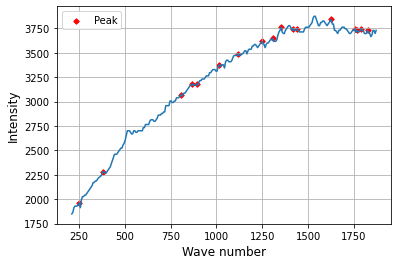

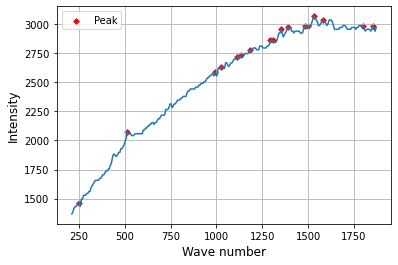

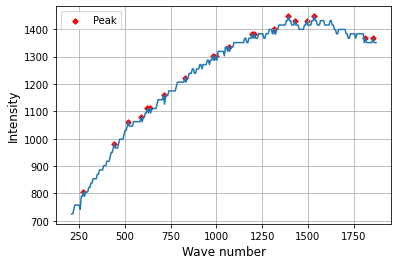

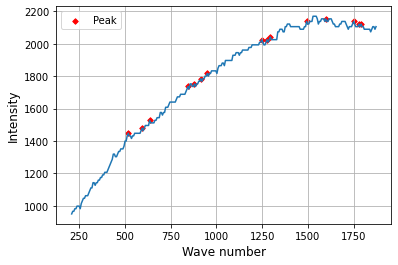

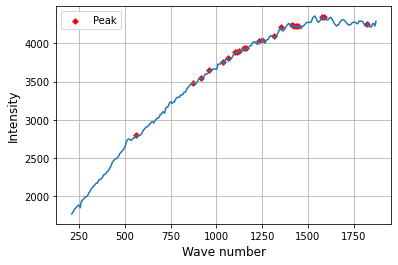

firstPointArrayPeaks:  [{'waveNumber': 250.72886297376093, 'intensity': 1961.847389558233}, {'waveNumber': 379.0087463556851, 'intensity': 2283.132530120482}, {'waveNumber': 804.6647230320699, 'intensity': 3070.281124497992}, {'waveNumber': 868.804664723032, 'intensity': 3182.7309236947794}, {'waveNumber': 892.1282798833819, 'intensity': 3182.7309236947794}, {'waveNumber': 1014.5772594752186, 'intensity': 3375.5020080321287}, {'waveNumber': 1119.533527696793, 'intensity': 3487.9518072289156}, {'waveNumber': 1247.813411078717, 'intensity': 3616.4658634538155}, {'waveNumber': 1306.1224489795918, 'intensity': 3648.5943775100404}, {'waveNumber': 1352.7696793002915, 'intensity': 3761.0441767068273}, {'waveNumber': 1416.9096209912536, 'intensity': 3744.979919678715}, {'waveNumber': 1440.2332361516035, 'intensity': 3744.979919678715}, {'waveNumber': 1626.8221574344022, 'intensity': 3841.3654618473897}, {'waveNumber': 1755.1020408163265, 'intensity': 3744.979919678715}, {'waveNumber': 1766.763

In [61]:
wb = Workbook()
ws = wb.active

# обработка изображений и получение данных
row = getResultsFromImg("img/samples/1.bmp", 1, 1)

vertLineCoords:  [{'x': 397, 'y': 57}, {'x': 397, 'y': 58}, {'x': 397, 'y': 59}, {'x': 397, 'y': 60}, {'x': 397, 'y': 61}, {'x': 397, 'y': 62}, {'x': 397, 'y': 63}, {'x': 397, 'y': 64}, {'x': 397, 'y': 65}, {'x': 397, 'y': 66}, {'x': 397, 'y': 67}, {'x': 397, 'y': 68}, {'x': 397, 'y': 69}, {'x': 397, 'y': 70}, {'x': 397, 'y': 71}, {'x': 397, 'y': 72}, {'x': 397, 'y': 73}, {'x': 397, 'y': 74}, {'x': 397, 'y': 75}, {'x': 397, 'y': 76}, {'x': 397, 'y': 77}, {'x': 397, 'y': 78}, {'x': 397, 'y': 79}, {'x': 397, 'y': 80}, {'x': 397, 'y': 81}, {'x': 397, 'y': 82}, {'x': 397, 'y': 83}, {'x': 397, 'y': 84}, {'x': 397, 'y': 85}, {'x': 397, 'y': 86}, {'x': 397, 'y': 87}, {'x': 397, 'y': 88}, {'x': 397, 'y': 89}, {'x': 397, 'y': 90}, {'x': 397, 'y': 91}, {'x': 397, 'y': 92}, {'x': 397, 'y': 93}, {'x': 397, 'y': 94}, {'x': 397, 'y': 95}, {'x': 397, 'y': 96}, {'x': 397, 'y': 97}, {'x': 397, 'y': 98}, {'x': 397, 'y': 99}, {'x': 397, 'y': 100}, {'x': 397, 'y': 101}, {'x': 397, 'y': 102}, {'x': 397, 'y

thresholdX:  {'smallThresholsX': 3, 'bigThresholsX': 6}
thresholdY:  {'smallThresholsY': 3, 'bigThresholsY': 6}
firstBigStrokeX:  {'x': 68, 'y': 324} lastBigStrokeX:  {'x': 427, 'y': 324}
firstBigStrokeY:  {'x': 68, 'y': 324} lastBigStrokeY:  {'x': 68, 'y': 74}
secondSmallStrokeX:  {'x': 409, 'y': 324}
maxValueY:  2400
maxValueX:  2000
minValueY:  400
minValueX:  0
img_1px_equel_func_valueX:  5.571030640668524
img_1px_equel_func_valueY:  8.0
firstPointArray:  [{'x': 38, 'y': 241.0}, {'x': 39, 'y': 240.0}, {'x': 40, 'y': 239.0}, {'x': 41, 'y': 238.0}, {'x': 42, 'y': 238.0}, {'x': 43, 'y': 237.0}, {'x': 44, 'y': 237.0}, {'x': 45, 'y': 236.0}, {'x': 46, 'y': 240.0}, {'x': 47, 'y': 235.0}, {'x': 48, 'y': 233.0}, {'x': 49, 'y': 233.0}, {'x': 50, 'y': 232.0}, {'x': 51, 'y': 231.0}, {'x': 52, 'y': 231.0}, {'x': 53, 'y': 230.0}, {'x': 54, 'y': 230.0}, {'x': 55, 'y': 230.0}, {'x': 56, 'y': 227.0}, {'x': 57, 'y': 227.0}, {'x': 58, 'y': 226.0}, {'x': 59, 'y': 224.0}, {'x': 60, 'y': 223.0}, {'x': 

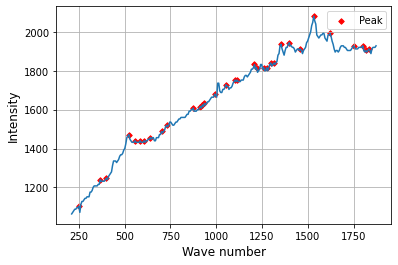

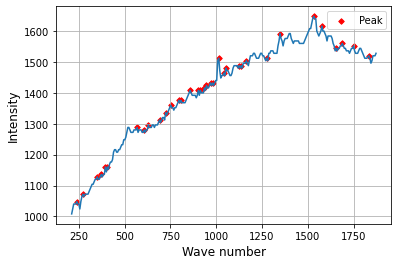

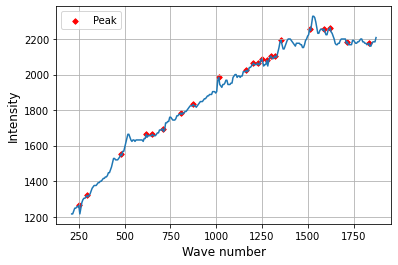

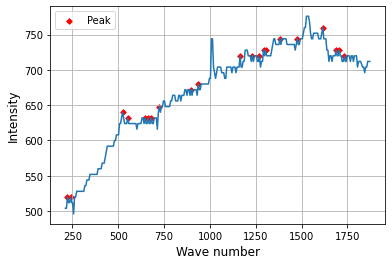

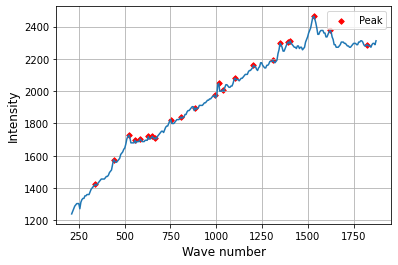

firstPointArrayPeaks:  [{'waveNumber': 250.69637883008357, 'intensity': 1104.0}, {'waveNumber': 367.68802228412255, 'intensity': 1240.0}, {'waveNumber': 401.11420612813373, 'intensity': 1248.0}, {'waveNumber': 523.6768802228413, 'intensity': 1472.0}, {'waveNumber': 557.1030640668524, 'intensity': 1440.0}, {'waveNumber': 584.9582172701951, 'intensity': 1440.0}, {'waveNumber': 607.2423398328691, 'intensity': 1440.0}, {'waveNumber': 640.6685236768802, 'intensity': 1456.0}, {'waveNumber': 701.949860724234, 'intensity': 1488.0}, {'waveNumber': 729.8050139275766, 'intensity': 1520.0}, {'waveNumber': 874.6518105849583, 'intensity': 1608.0}, {'waveNumber': 913.6490250696379, 'intensity': 1616.0}, {'waveNumber': 924.791086350975, 'intensity': 1624.0}, {'waveNumber': 935.9331476323121, 'intensity': 1632.0}, {'waveNumber': 991.6434540389972, 'intensity': 1680.0}, {'waveNumber': 1052.924791086351, 'intensity': 1728.0}, {'waveNumber': 1103.0640668523677, 'intensity': 1752.0}, {'waveNumber': 1114.20

In [62]:
row = getResultsFromImg("img/samples/2.bmp", 2, row + 3)

vertLineCoords:  [{'x': 446, 'y': 19}, {'x': 446, 'y': 20}, {'x': 446, 'y': 21}, {'x': 446, 'y': 22}, {'x': 446, 'y': 23}, {'x': 446, 'y': 24}, {'x': 446, 'y': 25}, {'x': 446, 'y': 26}, {'x': 446, 'y': 27}, {'x': 446, 'y': 28}, {'x': 446, 'y': 29}, {'x': 446, 'y': 30}, {'x': 446, 'y': 31}, {'x': 446, 'y': 32}, {'x': 446, 'y': 33}, {'x': 446, 'y': 34}, {'x': 446, 'y': 35}, {'x': 446, 'y': 36}, {'x': 446, 'y': 37}, {'x': 446, 'y': 38}, {'x': 446, 'y': 39}, {'x': 446, 'y': 40}, {'x': 446, 'y': 41}, {'x': 446, 'y': 42}, {'x': 446, 'y': 43}, {'x': 446, 'y': 44}, {'x': 446, 'y': 45}, {'x': 446, 'y': 46}, {'x': 446, 'y': 47}, {'x': 446, 'y': 48}, {'x': 446, 'y': 49}, {'x': 446, 'y': 50}, {'x': 446, 'y': 51}, {'x': 446, 'y': 52}, {'x': 446, 'y': 53}, {'x': 446, 'y': 54}, {'x': 446, 'y': 55}, {'x': 446, 'y': 56}, {'x': 446, 'y': 57}, {'x': 446, 'y': 58}, {'x': 446, 'y': 59}, {'x': 446, 'y': 60}, {'x': 446, 'y': 61}, {'x': 446, 'y': 62}, {'x': 446, 'y': 63}, {'x': 446, 'y': 64}, {'x': 446, 'y': 

thresholdY:  {'smallThresholsY': 3, 'bigThresholsY': 5}
firstBigStrokeX:  {'x': 107, 'y': 324} lastBigStrokeX:  {'x': 471, 'y': 324}
firstBigStrokeY:  {'x': 107, 'y': 308} lastBigStrokeY:  {'x': 107, 'y': 77}
secondSmallStrokeX:  {'x': 453, 'y': 324}
maxValueY:  9000
maxValueX:  2000
minValueY:  2000
minValueX:  0
img_1px_equel_func_valueX:  5.4945054945054945
img_1px_equel_func_valueY:  30.303030303030305
firstPointArray:  [{'x': 39, 'y': 218.0}, {'x': 40, 'y': 216.0}, {'x': 41, 'y': 215.0}, {'x': 42, 'y': 214.0}, {'x': 43, 'y': 213.0}, {'x': 44, 'y': 212.0}, {'x': 45, 'y': 212.0}, {'x': 46, 'y': 212.0}, {'x': 47, 'y': 214.0}, {'x': 48, 'y': 209.0}, {'x': 49, 'y': 208.0}, {'x': 50, 'y': 206.0}, {'x': 51, 'y': 206.0}, {'x': 52, 'y': 205.0}, {'x': 53, 'y': 204.0}, {'x': 54, 'y': 204.0}, {'x': 55, 'y': 203.0}, {'x': 56, 'y': 202.0}, {'x': 57, 'y': 201.0}, {'x': 58, 'y': 199.0}, {'x': 59, 'y': 197.0}, {'x': 60, 'y': 197.0}, {'x': 61, 'y': 196.0}, {'x': 62, 'y': 195.0}, {'x': 63, 'y': 195.

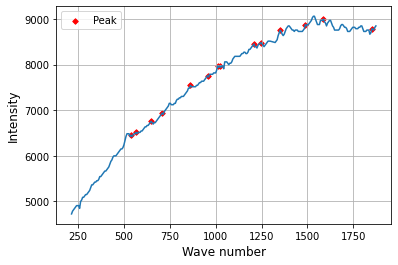

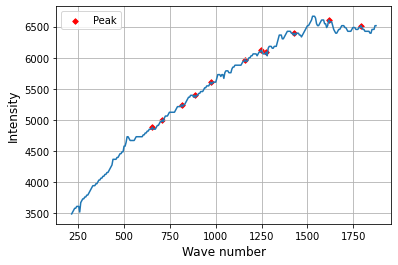

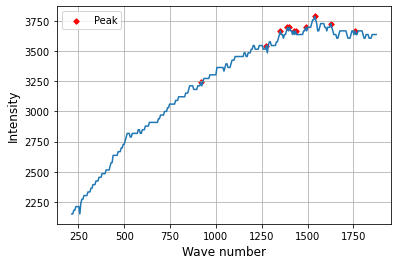

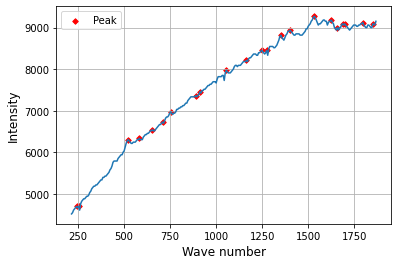

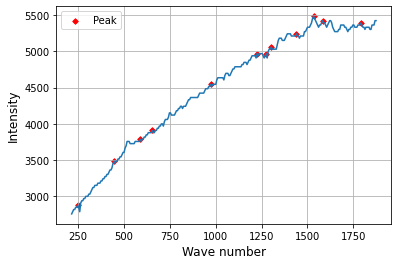

firstPointArrayPeaks:  [{'waveNumber': 538.4615384615385, 'intensity': 6454.545454545455}, {'waveNumber': 565.934065934066, 'intensity': 6515.151515151515}, {'waveNumber': 648.3516483516484, 'intensity': 6757.575757575758}, {'waveNumber': 708.7912087912088, 'intensity': 6939.39393939394}, {'waveNumber': 862.6373626373627, 'intensity': 7545.454545454546}, {'waveNumber': 956.0439560439561, 'intensity': 7757.575757575758}, {'waveNumber': 1010.989010989011, 'intensity': 7969.69696969697}, {'waveNumber': 1021.978021978022, 'intensity': 7969.69696969697}, {'waveNumber': 1208.7912087912089, 'intensity': 8454.545454545456}, {'waveNumber': 1247.2527472527472, 'intensity': 8484.848484848484}, {'waveNumber': 1351.6483516483518, 'intensity': 8757.575757575758}, {'waveNumber': 1489.010989010989, 'intensity': 8878.78787878788}, {'waveNumber': 1587.9120879120878, 'intensity': 9000.0}, {'waveNumber': 1851.6483516483518, 'intensity': 8787.878787878788}]
secondPointArrayPeaks:  [{'waveNumber': 653.84615

In [63]:
row = getResultsFromImg("img/samples/3.bmp", 3, row + 3)

vertLineCoords:  [{'x': 469, 'y': 65}, {'x': 469, 'y': 66}, {'x': 469, 'y': 67}, {'x': 469, 'y': 68}, {'x': 469, 'y': 69}, {'x': 469, 'y': 70}, {'x': 469, 'y': 71}, {'x': 469, 'y': 72}, {'x': 469, 'y': 73}, {'x': 469, 'y': 74}, {'x': 469, 'y': 75}, {'x': 469, 'y': 76}, {'x': 469, 'y': 77}, {'x': 469, 'y': 78}, {'x': 469, 'y': 79}, {'x': 469, 'y': 80}, {'x': 469, 'y': 81}, {'x': 469, 'y': 82}, {'x': 469, 'y': 83}, {'x': 469, 'y': 84}, {'x': 469, 'y': 85}, {'x': 469, 'y': 86}, {'x': 469, 'y': 87}, {'x': 469, 'y': 88}, {'x': 469, 'y': 89}, {'x': 469, 'y': 90}, {'x': 469, 'y': 91}, {'x': 469, 'y': 92}, {'x': 469, 'y': 93}, {'x': 469, 'y': 94}, {'x': 469, 'y': 95}, {'x': 469, 'y': 96}, {'x': 469, 'y': 97}, {'x': 469, 'y': 98}, {'x': 469, 'y': 99}, {'x': 469, 'y': 100}, {'x': 469, 'y': 101}, {'x': 469, 'y': 102}, {'x': 469, 'y': 103}, {'x': 469, 'y': 104}, {'x': 469, 'y': 105}, {'x': 469, 'y': 106}, {'x': 469, 'y': 107}, {'x': 469, 'y': 108}, {'x': 469, 'y': 109}, {'x': 469, 'y': 110}, {'x':

thresholdX:  {'smallThresholsX': 3, 'bigThresholsX': 6}
thresholdY:  {'smallThresholsY': 3, 'bigThresholsY': 6}
firstBigStrokeX:  {'x': 99, 'y': 349} lastBigStrokeX:  {'x': 496, 'y': 349}
firstBigStrokeY:  {'x': 99, 'y': 349} lastBigStrokeY:  {'x': 99, 'y': 94}
secondSmallStrokeX:  {'x': 476, 'y': 349}
maxValueY:  10000
maxValueX:  2000
minValueY:  0
minValueX:  0
img_1px_equel_func_valueX:  5.037783375314861
img_1px_equel_func_valueY:  39.21568627450981
firstPointArray:  [{'x': 42, 'y': 320.0}, {'x': 43, 'y': 319.0}, {'x': 44, 'y': 319.0}, {'x': 45, 'y': 319.0}, {'x': 46, 'y': 319.0}, {'x': 47, 'y': 319.0}, {'x': 48, 'y': 319.0}, {'x': 49, 'y': 319.0}, {'x': 50, 'y': 320.0}, {'x': 51, 'y': 320.0}, {'x': 52, 'y': 321.0}, {'x': 53, 'y': 320.0}, {'x': 54, 'y': 320.0}, {'x': 55, 'y': 320.0}, {'x': 56, 'y': 320.0}, {'x': 57, 'y': 320.0}, {'x': 58, 'y': 320.0}, {'x': 59, 'y': 321.0}, {'x': 60, 'y': 321.0}, {'x': 61, 'y': 321.0}, {'x': 62, 'y': 320.0}, {'x': 63, 'y': 320.0}, {'x': 64, 'y': 3

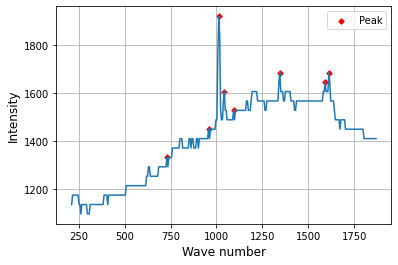

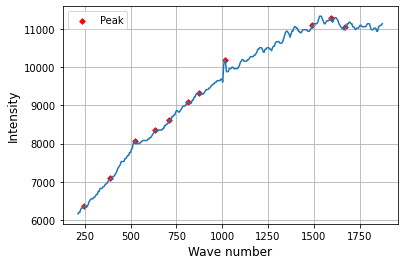

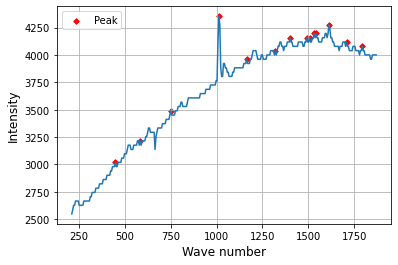

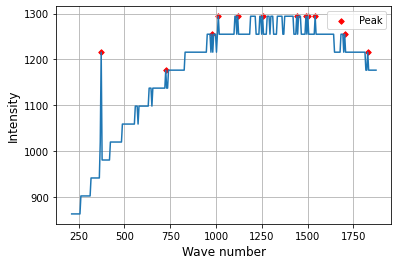

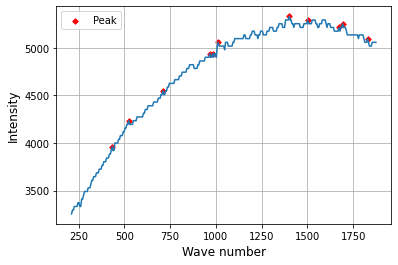

firstPointArrayPeaks:  [{'waveNumber': 730.4785894206549, 'intensity': 1333.3333333333335}, {'waveNumber': 957.1788413098236, 'intensity': 1450.9803921568628}, {'waveNumber': 1012.5944584382871, 'intensity': 1921.5686274509806}, {'waveNumber': 1042.8211586901762, 'intensity': 1607.843137254902}, {'waveNumber': 1093.1989924433249, 'intensity': 1529.4117647058824}, {'waveNumber': 1345.088161209068, 'intensity': 1686.2745098039218}, {'waveNumber': 1591.939546599496, 'intensity': 1647.058823529412}, {'waveNumber': 1612.0906801007554, 'intensity': 1686.2745098039218}]
secondPointArrayPeaks:  [{'waveNumber': 246.8513853904282, 'intensity': 6352.941176470588}, {'waveNumber': 387.9093198992443, 'intensity': 7098.039215686275}, {'waveNumber': 523.9294710327456, 'intensity': 8078.43137254902}, {'waveNumber': 634.7607052896725, 'intensity': 8352.94117647059}, {'waveNumber': 710.3274559193954, 'intensity': 8627.450980392157}, {'waveNumber': 811.0831234256926, 'intensity': 9098.039215686274}, {'wav

In [64]:
row = getResultsFromImg("img/samples/4.bmp", 4, row + 3)

axisYCoords:  [{'x': 75, 'y': 35}, {'x': 75, 'y': 36}, {'x': 75, 'y': 37}, {'x': 75, 'y': 38}, {'x': 75, 'y': 39}, {'x': 75, 'y': 40}, {'x': 75, 'y': 41}, {'x': 75, 'y': 42}, {'x': 75, 'y': 43}, {'x': 75, 'y': 44}, {'x': 75, 'y': 45}, {'x': 75, 'y': 46}, {'x': 75, 'y': 47}, {'x': 75, 'y': 48}, {'x': 75, 'y': 49}, {'x': 75, 'y': 50}, {'x': 75, 'y': 51}, {'x': 75, 'y': 52}, {'x': 75, 'y': 53}, {'x': 75, 'y': 54}, {'x': 75, 'y': 55}, {'x': 75, 'y': 56}, {'x': 75, 'y': 57}, {'x': 75, 'y': 58}, {'x': 75, 'y': 59}, {'x': 75, 'y': 60}, {'x': 75, 'y': 61}, {'x': 75, 'y': 62}, {'x': 75, 'y': 63}, {'x': 75, 'y': 64}, {'x': 75, 'y': 65}, {'x': 75, 'y': 66}, {'x': 75, 'y': 67}, {'x': 75, 'y': 68}, {'x': 75, 'y': 69}, {'x': 75, 'y': 70}, {'x': 75, 'y': 71}, {'x': 75, 'y': 72}, {'x': 75, 'y': 73}, {'x': 75, 'y': 74}, {'x': 75, 'y': 75}, {'x': 75, 'y': 76}, {'x': 75, 'y': 77}, {'x': 75, 'y': 78}, {'x': 75, 'y': 79}, {'x': 75, 'y': 80}, {'x': 75, 'y': 81}, {'x': 75, 'y': 82}, {'x': 75, 'y': 83}, {'x':

firstBigStrokeX:  {'x': 75, 'y': 309} lastBigStrokeX:  {'x': 432, 'y': 309}
firstBigStrokeY:  {'x': 75, 'y': 291} lastBigStrokeY:  {'x': 75, 'y': 51}
secondSmallStrokeX:  {'x': 414, 'y': 309}
maxValueY:  4000
maxValueX:  2000
minValueY:  500
minValueX:  0
img_1px_equel_func_valueX:  5.602240896358543
img_1px_equel_func_valueY:  14.583333333333334
firstPointArray:  [{'x': 38, 'y': 227.0}, {'x': 39, 'y': 226.0}, {'x': 40, 'y': 225.0}, {'x': 41, 'y': 224.0}, {'x': 42, 'y': 223.0}, {'x': 43, 'y': 222.0}, {'x': 44, 'y': 222.0}, {'x': 45, 'y': 221.0}, {'x': 46, 'y': 222.0}, {'x': 47, 'y': 218.0}, {'x': 48, 'y': 219.0}, {'x': 49, 'y': 217.0}, {'x': 50, 'y': 216.0}, {'x': 51, 'y': 216.0}, {'x': 52, 'y': 215.0}, {'x': 53, 'y': 215.0}, {'x': 54, 'y': 215.0}, {'x': 55, 'y': 214.0}, {'x': 56, 'y': 212.0}, {'x': 57, 'y': 212.0}, {'x': 58, 'y': 210.0}, {'x': 59, 'y': 209.0}, {'x': 60, 'y': 208.0}, {'x': 61, 'y': 207.0}, {'x': 62, 'y': 207.0}, {'x': 63, 'y': 207.0}, {'x': 64, 'y': 206.0}, {'x': 65, '

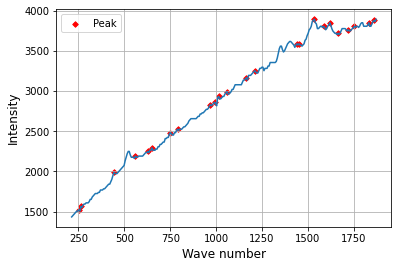

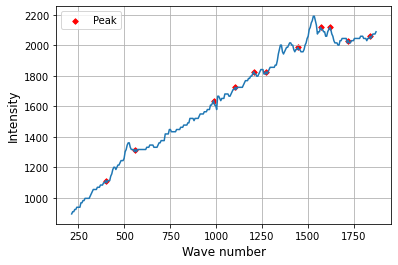

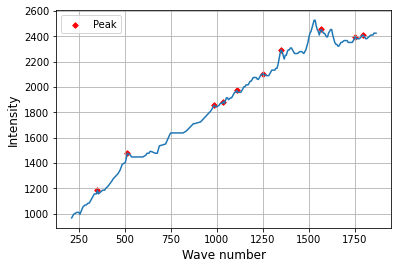

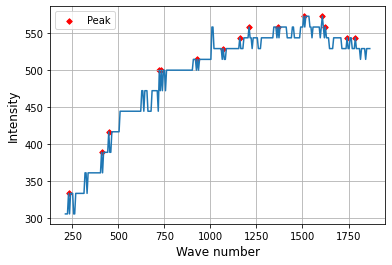

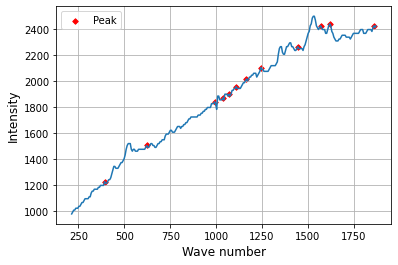

firstPointArrayPeaks:  [{'waveNumber': 252.10084033613444, 'intensity': 1520.8333333333335}, {'waveNumber': 263.3053221288515, 'intensity': 1564.5833333333335}, {'waveNumber': 442.5770308123249, 'intensity': 1987.5}, {'waveNumber': 560.2240896358543, 'intensity': 2191.666666666667}, {'waveNumber': 627.4509803921568, 'intensity': 2250.0}, {'waveNumber': 649.859943977591, 'intensity': 2293.75}, {'waveNumber': 750.7002801120448, 'intensity': 2483.3333333333335}, {'waveNumber': 789.9159663865546, 'intensity': 2527.0833333333335}, {'waveNumber': 969.1876750700279, 'intensity': 2833.3333333333335}, {'waveNumber': 991.5966386554621, 'intensity': 2862.5}, {'waveNumber': 1014.0056022408963, 'intensity': 2935.416666666667}, {'waveNumber': 1058.8235294117646, 'intensity': 2993.75}, {'waveNumber': 1165.266106442577, 'intensity': 3168.75}, {'waveNumber': 1210.0840336134454, 'intensity': 3256.25}, {'waveNumber': 1439.7759103641456, 'intensity': 3591.666666666667}, {'waveNumber': 1450.9803921568628, 

In [65]:
row = getResultsFromImg("img/samples/5.bmp", 5, row + 3)

axisYCoords:  [{'x': 81, 'y': 31}, {'x': 81, 'y': 32}, {'x': 81, 'y': 33}, {'x': 81, 'y': 34}, {'x': 81, 'y': 35}, {'x': 81, 'y': 36}, {'x': 81, 'y': 37}, {'x': 81, 'y': 38}, {'x': 81, 'y': 39}, {'x': 81, 'y': 40}, {'x': 81, 'y': 41}, {'x': 81, 'y': 42}, {'x': 81, 'y': 43}, {'x': 81, 'y': 44}, {'x': 81, 'y': 45}, {'x': 81, 'y': 46}, {'x': 81, 'y': 47}, {'x': 81, 'y': 48}, {'x': 81, 'y': 49}, {'x': 81, 'y': 50}, {'x': 81, 'y': 51}, {'x': 81, 'y': 52}, {'x': 81, 'y': 53}, {'x': 81, 'y': 54}, {'x': 81, 'y': 55}, {'x': 81, 'y': 56}, {'x': 81, 'y': 57}, {'x': 81, 'y': 58}, {'x': 81, 'y': 59}, {'x': 81, 'y': 60}, {'x': 81, 'y': 61}, {'x': 81, 'y': 62}, {'x': 81, 'y': 63}, {'x': 81, 'y': 64}, {'x': 81, 'y': 65}, {'x': 81, 'y': 66}, {'x': 81, 'y': 67}, {'x': 81, 'y': 68}, {'x': 81, 'y': 69}, {'x': 81, 'y': 70}, {'x': 81, 'y': 71}, {'x': 81, 'y': 72}, {'x': 81, 'y': 73}, {'x': 81, 'y': 74}, {'x': 81, 'y': 75}, {'x': 81, 'y': 76}, {'x': 81, 'y': 77}, {'x': 81, 'y': 78}, {'x': 81, 'y': 79}, {'x':

firstBigStrokeX:  {'x': 81, 'y': 305} lastBigStrokeX:  {'x': 438, 'y': 305}
firstBigStrokeY:  {'x': 81, 'y': 305} lastBigStrokeY:  {'x': 81, 'y': 55}
secondSmallStrokeX:  {'x': 420, 'y': 305}
maxValueY:  6000
maxValueX:  2000
minValueY:  1000
minValueX:  0
img_1px_equel_func_valueX:  5.602240896358543
img_1px_equel_func_valueY:  20.0
firstPointArray:  [{'x': 38, 'y': 191.0}, {'x': 39, 'y': 190.0}, {'x': 40, 'y': 188.0}, {'x': 41, 'y': 187.0}, {'x': 42, 'y': 187.0}, {'x': 43, 'y': 186.0}, {'x': 44, 'y': 187.0}, {'x': 45, 'y': 186.0}, {'x': 46, 'y': 189.0}, {'x': 47, 'y': 185.0}, {'x': 48, 'y': 183.0}, {'x': 49, 'y': 182.0}, {'x': 50, 'y': 182.0}, {'x': 51, 'y': 181.0}, {'x': 52, 'y': 180.0}, {'x': 53, 'y': 180.0}, {'x': 54, 'y': 180.0}, {'x': 55, 'y': 179.0}, {'x': 56, 'y': 178.0}, {'x': 57, 'y': 177.0}, {'x': 58, 'y': 176.0}, {'x': 59, 'y': 174.0}, {'x': 60, 'y': 173.0}, {'x': 61, 'y': 173.0}, {'x': 62, 'y': 172.0}, {'x': 63, 'y': 172.0}, {'x': 64, 'y': 172.0}, {'x': 65, 'y': 170.0}, {

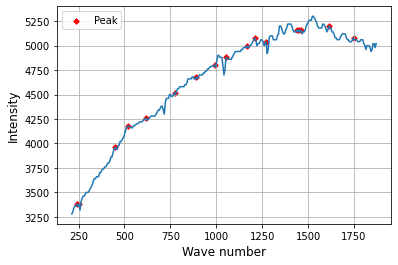

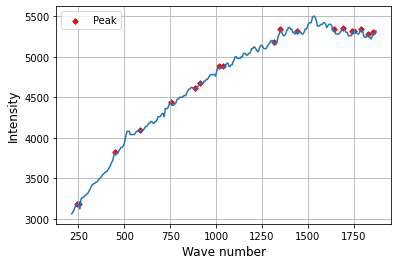

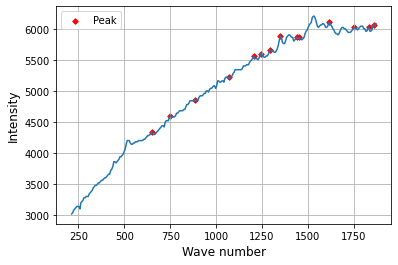

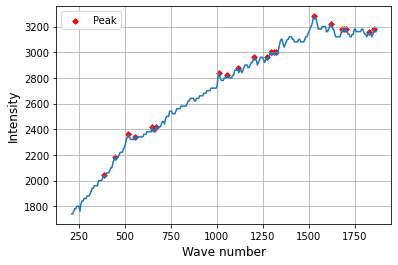

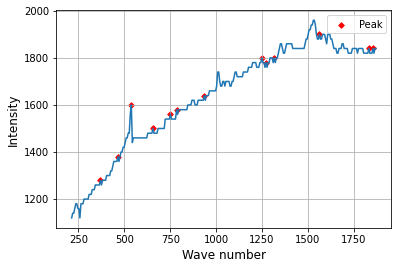

firstPointArrayPeaks:  [{'waveNumber': 240.89635854341736, 'intensity': 3380.0}, {'waveNumber': 252.10084033613444, 'intensity': 3380.0}, {'waveNumber': 448.1792717086835, 'intensity': 3960.0}, {'waveNumber': 521.0084033613444, 'intensity': 4180.0}, {'waveNumber': 616.2464985994397, 'intensity': 4260.0}, {'waveNumber': 773.109243697479, 'intensity': 4520.0}, {'waveNumber': 890.7563025210084, 'intensity': 4680.0}, {'waveNumber': 991.5966386554621, 'intensity': 4800.0}, {'waveNumber': 1053.221288515406, 'intensity': 4880.0}, {'waveNumber': 1165.266106442577, 'intensity': 5000.0}, {'waveNumber': 1210.0840336134454, 'intensity': 5080.0}, {'waveNumber': 1271.7086834733893, 'intensity': 5040.0}, {'waveNumber': 1439.7759103641456, 'intensity': 5160.0}, {'waveNumber': 1450.9803921568628, 'intensity': 5160.0}, {'waveNumber': 1462.1848739495797, 'intensity': 5160.0}, {'waveNumber': 1613.4453781512605, 'intensity': 5200.0}, {'waveNumber': 1747.8991596638655, 'intensity': 5080.0}]
secondPointArray

In [66]:
row = getResultsFromImg("img/samples/6.bmp", 6, row + 3)

axisYCoords:  [{'x': 97, 'y': 33}, {'x': 97, 'y': 34}, {'x': 97, 'y': 35}, {'x': 97, 'y': 36}, {'x': 97, 'y': 37}, {'x': 97, 'y': 38}, {'x': 97, 'y': 39}, {'x': 97, 'y': 40}, {'x': 97, 'y': 41}, {'x': 97, 'y': 42}, {'x': 97, 'y': 43}, {'x': 97, 'y': 44}, {'x': 97, 'y': 45}, {'x': 97, 'y': 46}, {'x': 97, 'y': 47}, {'x': 97, 'y': 48}, {'x': 97, 'y': 49}, {'x': 97, 'y': 50}, {'x': 97, 'y': 51}, {'x': 97, 'y': 52}, {'x': 97, 'y': 53}, {'x': 97, 'y': 54}, {'x': 97, 'y': 55}, {'x': 97, 'y': 56}, {'x': 97, 'y': 57}, {'x': 97, 'y': 58}, {'x': 97, 'y': 59}, {'x': 97, 'y': 60}, {'x': 97, 'y': 61}, {'x': 97, 'y': 62}, {'x': 97, 'y': 63}, {'x': 97, 'y': 64}, {'x': 97, 'y': 65}, {'x': 97, 'y': 66}, {'x': 97, 'y': 67}, {'x': 97, 'y': 68}, {'x': 97, 'y': 69}, {'x': 97, 'y': 70}, {'x': 97, 'y': 71}, {'x': 97, 'y': 72}, {'x': 97, 'y': 73}, {'x': 97, 'y': 74}, {'x': 97, 'y': 75}, {'x': 97, 'y': 76}, {'x': 97, 'y': 77}, {'x': 97, 'y': 78}, {'x': 97, 'y': 79}, {'x': 97, 'y': 80}, {'x': 97, 'y': 81}, {'x':

firstBigStrokeX:  {'x': 97, 'y': 317} lastBigStrokeX:  {'x': 467, 'y': 317}
firstBigStrokeY:  {'x': 97, 'y': 317} lastBigStrokeY:  {'x': 97, 'y': 40}
secondSmallStrokeX:  {'x': 449, 'y': 317}
maxValueY:  11000
maxValueX:  2000
minValueY:  2000
minValueX:  0
img_1px_equel_func_valueX:  5.405405405405405
img_1px_equel_func_valueY:  32.49097472924188
firstPointArray:  [{'x': 39, 'y': 153.0}, {'x': 40, 'y': 151.0}, {'x': 41, 'y': 149.0}, {'x': 42, 'y': 148.0}, {'x': 43, 'y': 147.0}, {'x': 44, 'y': 147.0}, {'x': 45, 'y': 147.0}, {'x': 46, 'y': 147.0}, {'x': 47, 'y': 148.0}, {'x': 48, 'y': 144.0}, {'x': 49, 'y': 143.0}, {'x': 50, 'y': 140.0}, {'x': 51, 'y': 139.0}, {'x': 52, 'y': 138.0}, {'x': 53, 'y': 138.0}, {'x': 54, 'y': 137.0}, {'x': 55, 'y': 137.0}, {'x': 56, 'y': 136.0}, {'x': 57, 'y': 134.0}, {'x': 58, 'y': 133.0}, {'x': 59, 'y': 132.0}, {'x': 60, 'y': 130.0}, {'x': 61, 'y': 129.0}, {'x': 62, 'y': 128.0}, {'x': 63, 'y': 128.0}, {'x': 64, 'y': 126.0}, {'x': 65, 'y': 126.0}, {'x': 66, 

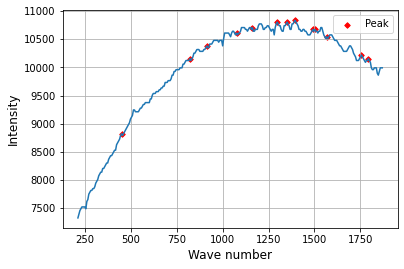

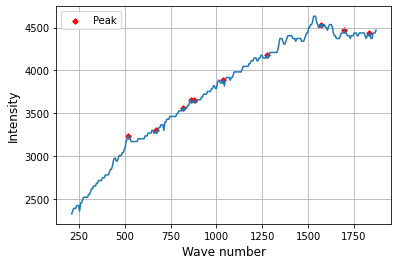

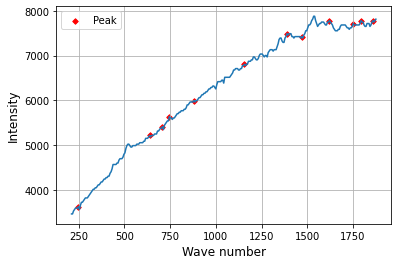

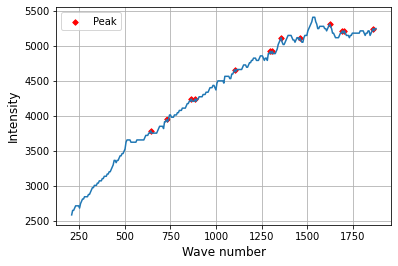

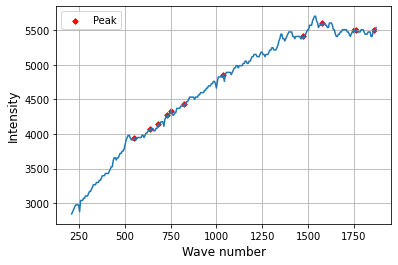

firstPointArrayPeaks:  [{'waveNumber': 448.64864864864865, 'intensity': 8823.104693140795}, {'waveNumber': 821.6216216216216, 'intensity': 10155.234657039711}, {'waveNumber': 913.5135135135135, 'intensity': 10382.671480144405}, {'waveNumber': 1075.6756756756756, 'intensity': 10610.108303249097}, {'waveNumber': 1162.162162162162, 'intensity': 10707.581227436824}, {'waveNumber': 1297.2972972972973, 'intensity': 10805.054151624548}, {'waveNumber': 1351.3513513513512, 'intensity': 10805.054151624548}, {'waveNumber': 1394.5945945945946, 'intensity': 10837.54512635379}, {'waveNumber': 1491.8918918918919, 'intensity': 10675.090252707581}, {'waveNumber': 1502.7027027027027, 'intensity': 10675.090252707581}, {'waveNumber': 1567.5675675675675, 'intensity': 10545.126353790614}, {'waveNumber': 1756.7567567567567, 'intensity': 10220.216606498196}, {'waveNumber': 1794.5945945945946, 'intensity': 10155.234657039711}]
secondPointArrayPeaks:  [{'waveNumber': 518.918918918919, 'intensity': 3234.65703971

In [67]:
row = getResultsFromImg("img/samples/7.bmp", 7, row + 3)

axisYCoords:  [{'x': 90, 'y': 41}, {'x': 90, 'y': 42}, {'x': 90, 'y': 43}, {'x': 90, 'y': 44}, {'x': 90, 'y': 45}, {'x': 90, 'y': 46}, {'x': 90, 'y': 47}, {'x': 90, 'y': 48}, {'x': 90, 'y': 49}, {'x': 90, 'y': 50}, {'x': 90, 'y': 51}, {'x': 90, 'y': 52}, {'x': 90, 'y': 53}, {'x': 90, 'y': 54}, {'x': 90, 'y': 55}, {'x': 90, 'y': 56}, {'x': 90, 'y': 57}, {'x': 90, 'y': 58}, {'x': 90, 'y': 59}, {'x': 90, 'y': 60}, {'x': 90, 'y': 61}, {'x': 90, 'y': 62}, {'x': 90, 'y': 63}, {'x': 90, 'y': 64}, {'x': 90, 'y': 65}, {'x': 90, 'y': 66}, {'x': 90, 'y': 67}, {'x': 90, 'y': 68}, {'x': 90, 'y': 69}, {'x': 90, 'y': 70}, {'x': 90, 'y': 71}, {'x': 90, 'y': 72}, {'x': 90, 'y': 73}, {'x': 90, 'y': 74}, {'x': 90, 'y': 75}, {'x': 90, 'y': 76}, {'x': 90, 'y': 77}, {'x': 90, 'y': 78}, {'x': 90, 'y': 79}, {'x': 90, 'y': 80}, {'x': 90, 'y': 81}, {'x': 90, 'y': 82}, {'x': 90, 'y': 83}, {'x': 90, 'y': 84}, {'x': 90, 'y': 85}, {'x': 90, 'y': 86}, {'x': 90, 'y': 87}, {'x': 90, 'y': 88}, {'x': 90, 'y': 89}, {'x':

thresholdX:  {'smallThresholsX': 3, 'bigThresholsX': 5}
thresholdY:  {'smallThresholsY': 2, 'bigThresholsY': 5}
firstBigStrokeX:  {'x': 90, 'y': 325} lastBigStrokeX:  {'x': 459, 'y': 325}
firstBigStrokeY:  {'x': 90, 'y': 325} lastBigStrokeY:  {'x': 90, 'y': 50}
secondSmallStrokeX:  {'x': 440, 'y': 325}
maxValueY:  2800
maxValueX:  2000
minValueY:  200
minValueX:  0
img_1px_equel_func_valueX:  5.420054200542006
img_1px_equel_func_valueY:  9.454545454545455
firstPointArray:  [{'x': 39, 'y': 194.0}, {'x': 40, 'y': 193.0}, {'x': 41, 'y': 191.0}, {'x': 42, 'y': 189.0}, {'x': 43, 'y': 189.0}, {'x': 44, 'y': 188.0}, {'x': 45, 'y': 189.0}, {'x': 46, 'y': 187.0}, {'x': 47, 'y': 187.0}, {'x': 48, 'y': 191.0}, {'x': 49, 'y': 186.0}, {'x': 50, 'y': 185.0}, {'x': 51, 'y': 184.0}, {'x': 52, 'y': 183.0}, {'x': 53, 'y': 182.0}, {'x': 54, 'y': 181.0}, {'x': 55, 'y': 182.0}, {'x': 56, 'y': 181.0}, {'x': 57, 'y': 181.0}, {'x': 58, 'y': 179.0}, {'x': 59, 'y': 178.0}, {'x': 60, 'y': 177.0}, {'x': 61, 'y': 

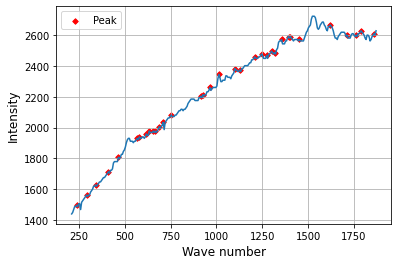

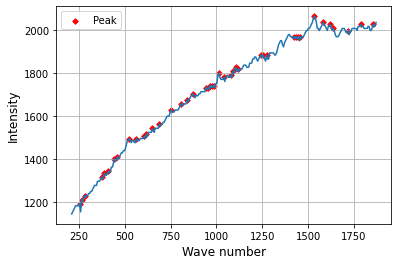

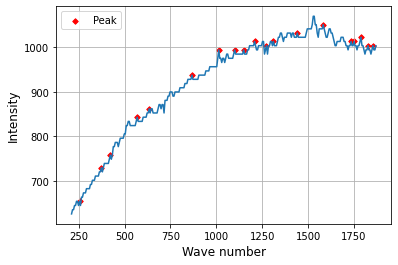

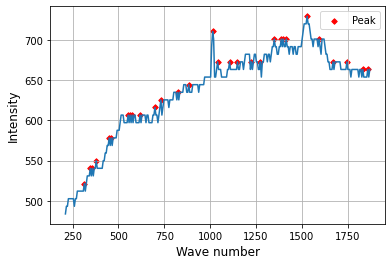

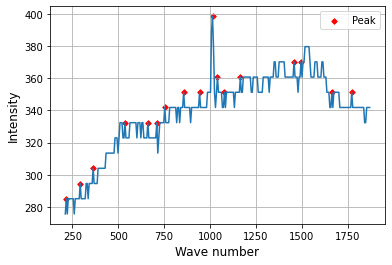

firstPointArrayPeaks:  [{'waveNumber': 238.48238482384824, 'intensity': 1495.2727272727273}, {'waveNumber': 292.6829268292683, 'intensity': 1561.4545454545455}, {'waveNumber': 341.4634146341464, 'intensity': 1627.6363636363637}, {'waveNumber': 411.92411924119244, 'intensity': 1712.7272727272727}, {'waveNumber': 466.1246612466125, 'intensity': 1807.2727272727273}, {'waveNumber': 569.1056910569106, 'intensity': 1930.1818181818182}, {'waveNumber': 579.9457994579946, 'intensity': 1939.6363636363637}, {'waveNumber': 617.8861788617886, 'intensity': 1958.5454545454547}, {'waveNumber': 634.1463414634146, 'intensity': 1977.4545454545455}, {'waveNumber': 655.8265582655827, 'intensity': 1977.4545454545455}, {'waveNumber': 666.6666666666667, 'intensity': 1977.4545454545455}, {'waveNumber': 688.3468834688347, 'intensity': 2005.818181818182}, {'waveNumber': 710.0271002710027, 'intensity': 2034.1818181818182}, {'waveNumber': 753.3875338753388, 'intensity': 2081.4545454545455}, {'waveNumber': 915.9891

In [68]:
row = getResultsFromImg("img/samples/8.bmp", 8, row + 3)

axisYCoords:  [{'x': 97, 'y': 47}, {'x': 97, 'y': 48}, {'x': 97, 'y': 49}, {'x': 97, 'y': 50}, {'x': 97, 'y': 51}, {'x': 97, 'y': 52}, {'x': 97, 'y': 53}, {'x': 97, 'y': 54}, {'x': 97, 'y': 55}, {'x': 97, 'y': 56}, {'x': 97, 'y': 57}, {'x': 97, 'y': 58}, {'x': 97, 'y': 59}, {'x': 97, 'y': 60}, {'x': 97, 'y': 61}, {'x': 97, 'y': 62}, {'x': 97, 'y': 63}, {'x': 97, 'y': 64}, {'x': 97, 'y': 65}, {'x': 97, 'y': 66}, {'x': 97, 'y': 67}, {'x': 97, 'y': 68}, {'x': 97, 'y': 69}, {'x': 97, 'y': 70}, {'x': 97, 'y': 71}, {'x': 97, 'y': 72}, {'x': 97, 'y': 73}, {'x': 97, 'y': 74}, {'x': 97, 'y': 75}, {'x': 97, 'y': 76}, {'x': 97, 'y': 77}, {'x': 97, 'y': 78}, {'x': 97, 'y': 79}, {'x': 97, 'y': 80}, {'x': 97, 'y': 81}, {'x': 97, 'y': 82}, {'x': 97, 'y': 83}, {'x': 97, 'y': 84}, {'x': 97, 'y': 85}, {'x': 97, 'y': 86}, {'x': 97, 'y': 87}, {'x': 97, 'y': 88}, {'x': 97, 'y': 89}, {'x': 97, 'y': 90}, {'x': 97, 'y': 91}, {'x': 97, 'y': 92}, {'x': 97, 'y': 93}, {'x': 97, 'y': 94}, {'x': 97, 'y': 95}, {'x':

firstBigStrokeX:  {'x': 97, 'y': 327} lastBigStrokeX:  {'x': 461, 'y': 327}
firstBigStrokeY:  {'x': 97, 'y': 327} lastBigStrokeY:  {'x': 97, 'y': 58}
secondSmallStrokeX:  {'x': 443, 'y': 327}
maxValueY:  8000
maxValueX:  2000
minValueY:  2000
minValueX:  0
img_1px_equel_func_valueX:  5.4945054945054945
img_1px_equel_func_valueY:  22.304832713754646
firstPointArray:  [{'x': 38, 'y': 315.0}, {'x': 39, 'y': 315.0}, {'x': 40, 'y': 313.0}, {'x': 41, 'y': 312.0}, {'x': 42, 'y': 312.0}, {'x': 43, 'y': 311.0}, {'x': 44, 'y': 311.0}, {'x': 45, 'y': 311.0}, {'x': 46, 'y': 312.0}, {'x': 47, 'y': 311.0}, {'x': 48, 'y': 309.0}, {'x': 49, 'y': 309.0}, {'x': 50, 'y': 308.0}, {'x': 51, 'y': 308.0}, {'x': 52, 'y': 307.0}, {'x': 53, 'y': 307.0}, {'x': 54, 'y': 307.0}, {'x': 55, 'y': 306.0}, {'x': 56, 'y': 306.0}, {'x': 57, 'y': 305.0}, {'x': 58, 'y': 304.0}, {'x': 59, 'y': 303.0}, {'x': 60, 'y': 302.0}, {'x': 61, 'y': 302.0}, {'x': 62, 'y': 302.0}, {'x': 63, 'y': 301.0}, {'x': 64, 'y': 301.0}, {'x': 65,

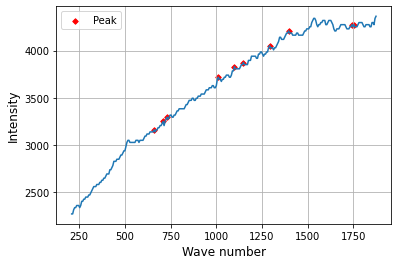

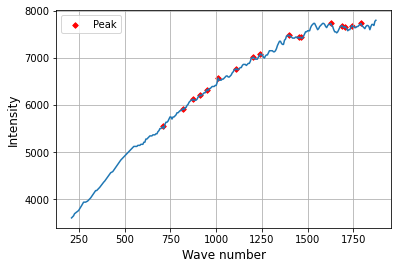

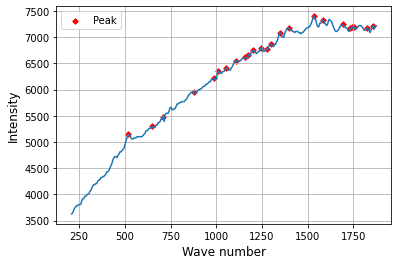

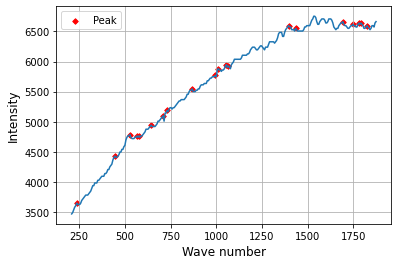

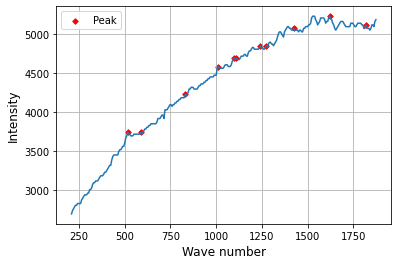

firstPointArrayPeaks:  [{'waveNumber': 659.3406593406594, 'intensity': 3159.8513011152418}, {'waveNumber': 708.7912087912088, 'intensity': 3249.0706319702604}, {'waveNumber': 730.7692307692307, 'intensity': 3293.680297397769}, {'waveNumber': 1010.989010989011, 'intensity': 3717.472118959108}, {'waveNumber': 1098.901098901099, 'intensity': 3828.996282527881}, {'waveNumber': 1148.3516483516485, 'intensity': 3873.6059479553905}, {'waveNumber': 1291.2087912087911, 'intensity': 4052.0446096654273}, {'waveNumber': 1395.6043956043957, 'intensity': 4208.17843866171}, {'waveNumber': 1741.7582417582419, 'intensity': 4275.092936802974}, {'waveNumber': 1752.7472527472528, 'intensity': 4275.092936802974}]
secondPointArrayPeaks:  [{'waveNumber': 708.7912087912088, 'intensity': 5546.468401486989}, {'waveNumber': 818.6813186813187, 'intensity': 5925.650557620818}, {'waveNumber': 873.6263736263736, 'intensity': 6126.394052044609}, {'waveNumber': 912.0879120879121, 'intensity': 6215.613382899628}, {'wav

In [69]:
row = getResultsFromImg("img/samples/9.bmp", 9, row + 3)

axisYCoords:  [{'x': 79, 'y': 39}, {'x': 79, 'y': 40}, {'x': 79, 'y': 41}, {'x': 79, 'y': 42}, {'x': 79, 'y': 43}, {'x': 79, 'y': 44}, {'x': 79, 'y': 45}, {'x': 79, 'y': 46}, {'x': 79, 'y': 47}, {'x': 79, 'y': 48}, {'x': 79, 'y': 49}, {'x': 79, 'y': 50}, {'x': 79, 'y': 51}, {'x': 79, 'y': 52}, {'x': 79, 'y': 53}, {'x': 79, 'y': 54}, {'x': 79, 'y': 55}, {'x': 79, 'y': 56}, {'x': 79, 'y': 57}, {'x': 79, 'y': 58}, {'x': 79, 'y': 59}, {'x': 79, 'y': 60}, {'x': 79, 'y': 61}, {'x': 79, 'y': 62}, {'x': 79, 'y': 63}, {'x': 79, 'y': 64}, {'x': 79, 'y': 65}, {'x': 79, 'y': 66}, {'x': 79, 'y': 67}, {'x': 79, 'y': 68}, {'x': 79, 'y': 69}, {'x': 79, 'y': 70}, {'x': 79, 'y': 71}, {'x': 79, 'y': 72}, {'x': 79, 'y': 73}, {'x': 79, 'y': 74}, {'x': 79, 'y': 75}, {'x': 79, 'y': 76}, {'x': 79, 'y': 77}, {'x': 79, 'y': 78}, {'x': 79, 'y': 79}, {'x': 79, 'y': 80}, {'x': 79, 'y': 81}, {'x': 79, 'y': 82}, {'x': 79, 'y': 83}, {'x': 79, 'y': 84}, {'x': 79, 'y': 85}, {'x': 79, 'y': 86}, {'x': 79, 'y': 87}, {'x':

firstBigStrokeX:  {'x': 79, 'y': 321} lastBigStrokeX:  {'x': 446, 'y': 321}
firstBigStrokeY:  {'x': 79, 'y': 321} lastBigStrokeY:  {'x': 79, 'y': 46}
secondSmallStrokeX:  {'x': 428, 'y': 321}
maxValueY:  9500
maxValueX:  2000
minValueY:  1000
minValueX:  0
img_1px_equel_func_valueX:  5.449591280653951
img_1px_equel_func_valueY:  30.90909090909091
firstPointArray:  [{'x': 39, 'y': 295.0}, {'x': 40, 'y': 294.0}, {'x': 41, 'y': 293.0}, {'x': 42, 'y': 293.0}, {'x': 43, 'y': 293.0}, {'x': 44, 'y': 292.0}, {'x': 45, 'y': 292.0}, {'x': 46, 'y': 292.0}, {'x': 47, 'y': 292.0}, {'x': 48, 'y': 292.0}, {'x': 49, 'y': 291.0}, {'x': 50, 'y': 291.0}, {'x': 51, 'y': 290.0}, {'x': 52, 'y': 290.0}, {'x': 53, 'y': 290.0}, {'x': 54, 'y': 289.0}, {'x': 55, 'y': 289.0}, {'x': 56, 'y': 288.0}, {'x': 57, 'y': 288.0}, {'x': 58, 'y': 288.0}, {'x': 59, 'y': 287.0}, {'x': 60, 'y': 287.0}, {'x': 61, 'y': 286.0}, {'x': 62, 'y': 286.0}, {'x': 63, 'y': 286.0}, {'x': 64, 'y': 285.0}, {'x': 65, 'y': 285.0}, {'x': 66, '

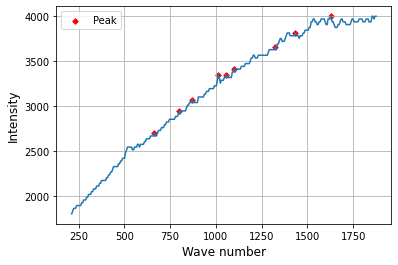

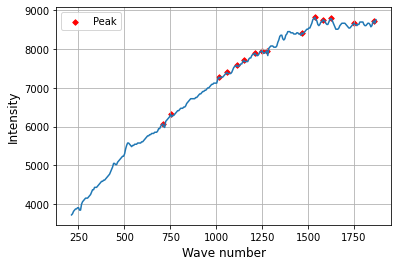

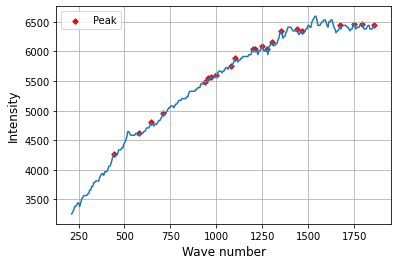

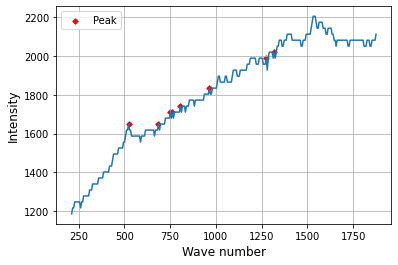

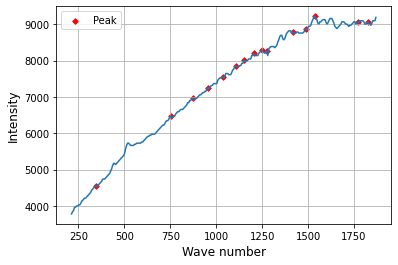

firstPointArrayPeaks:  [{'waveNumber': 664.8501362397819, 'intensity': 2700.0}, {'waveNumber': 801.0899182561308, 'intensity': 2947.272727272727}, {'waveNumber': 871.9346049046321, 'intensity': 3070.909090909091}, {'waveNumber': 1013.6239782016348, 'intensity': 3349.090909090909}, {'waveNumber': 1057.2207084468664, 'intensity': 3349.090909090909}, {'waveNumber': 1100.817438692098, 'intensity': 3410.909090909091}, {'waveNumber': 1324.25068119891, 'intensity': 3658.1818181818185}, {'waveNumber': 1433.242506811989, 'intensity': 3812.727272727273}, {'waveNumber': 1629.4277929155312, 'intensity': 3998.1818181818185}]
secondPointArrayPeaks:  [{'waveNumber': 708.4468664850136, 'intensity': 6069.090909090909}, {'waveNumber': 752.0435967302452, 'intensity': 6316.363636363637}, {'waveNumber': 1013.6239782016348, 'intensity': 7274.545454545455}, {'waveNumber': 1057.2207084468664, 'intensity': 7398.181818181818}, {'waveNumber': 1111.716621253406, 'intensity': 7583.636363636364}, {'waveNumber': 114

In [70]:
row = getResultsFromImg("img/samples/10.bmp", 10, row + 3)

axisYCoords:  [{'x': 82, 'y': 27}, {'x': 82, 'y': 28}, {'x': 82, 'y': 29}, {'x': 82, 'y': 30}, {'x': 82, 'y': 31}, {'x': 82, 'y': 32}, {'x': 82, 'y': 33}, {'x': 82, 'y': 34}, {'x': 82, 'y': 35}, {'x': 82, 'y': 36}, {'x': 82, 'y': 37}, {'x': 82, 'y': 38}, {'x': 82, 'y': 39}, {'x': 82, 'y': 40}, {'x': 82, 'y': 41}, {'x': 82, 'y': 42}, {'x': 82, 'y': 43}, {'x': 82, 'y': 44}, {'x': 82, 'y': 45}, {'x': 82, 'y': 46}, {'x': 82, 'y': 47}, {'x': 82, 'y': 48}, {'x': 82, 'y': 49}, {'x': 82, 'y': 50}, {'x': 82, 'y': 51}, {'x': 82, 'y': 52}, {'x': 82, 'y': 53}, {'x': 82, 'y': 54}, {'x': 82, 'y': 55}, {'x': 82, 'y': 56}, {'x': 82, 'y': 57}, {'x': 82, 'y': 58}, {'x': 82, 'y': 59}, {'x': 82, 'y': 60}, {'x': 82, 'y': 61}, {'x': 82, 'y': 62}, {'x': 82, 'y': 63}, {'x': 82, 'y': 64}, {'x': 82, 'y': 65}, {'x': 82, 'y': 66}, {'x': 82, 'y': 67}, {'x': 82, 'y': 68}, {'x': 82, 'y': 69}, {'x': 82, 'y': 70}, {'x': 82, 'y': 71}, {'x': 82, 'y': 72}, {'x': 82, 'y': 73}, {'x': 82, 'y': 74}, {'x': 82, 'y': 75}, {'x':

firstBigStrokeX:  {'x': 82, 'y': 311} lastBigStrokeX:  {'x': 453, 'y': 311}
firstBigStrokeY:  {'x': 82, 'y': 311} lastBigStrokeY:  {'x': 82, 'y': 42}
secondSmallStrokeX:  {'x': 434, 'y': 311}
maxValueY:  4500
maxValueX:  2000
minValueY:  500
minValueX:  0
img_1px_equel_func_valueX:  5.390835579514825
img_1px_equel_func_valueY:  14.869888475836431
firstPointArray:  [{'x': 39, 'y': 173.0}, {'x': 40, 'y': 170.0}, {'x': 41, 'y': 169.0}, {'x': 42, 'y': 168.0}, {'x': 43, 'y': 168.0}, {'x': 44, 'y': 168.0}, {'x': 45, 'y': 168.0}, {'x': 46, 'y': 169.0}, {'x': 47, 'y': 168.0}, {'x': 48, 'y': 169.0}, {'x': 49, 'y': 167.0}, {'x': 50, 'y': 166.0}, {'x': 51, 'y': 165.0}, {'x': 52, 'y': 163.0}, {'x': 53, 'y': 163.0}, {'x': 54, 'y': 163.0}, {'x': 55, 'y': 164.0}, {'x': 56, 'y': 164.0}, {'x': 57, 'y': 163.0}, {'x': 58, 'y': 162.0}, {'x': 59, 'y': 161.0}, {'x': 60, 'y': 159.0}, {'x': 61, 'y': 158.0}, {'x': 62, 'y': 158.0}, {'x': 63, 'y': 158.0}, {'x': 64, 'y': 157.0}, {'x': 65, 'y': 158.0}, {'x': 66, '

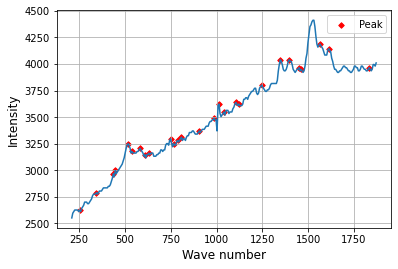

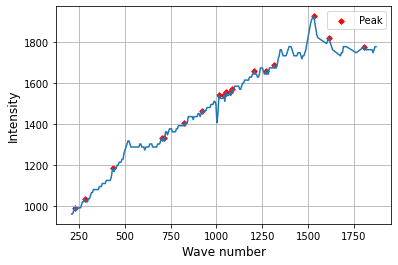

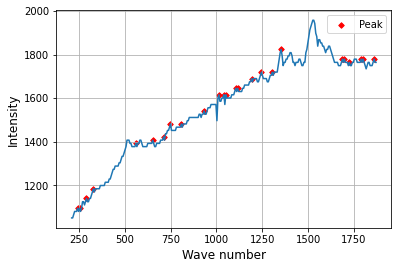

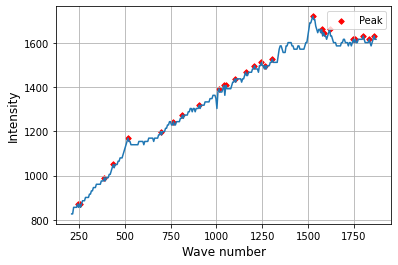

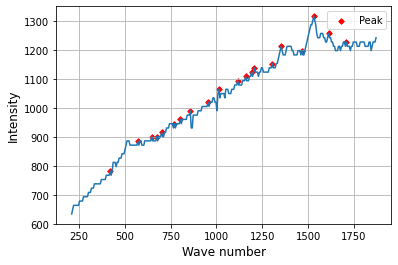

firstPointArrayPeaks:  [{'waveNumber': 253.36927223719675, 'intensity': 2626.3940520446095}, {'waveNumber': 345.0134770889488, 'intensity': 2789.96282527881}, {'waveNumber': 436.6576819407008, 'intensity': 2968.4014869888474}, {'waveNumber': 447.43935309973045, 'intensity': 2998.1412639405203}, {'waveNumber': 517.5202156334232, 'intensity': 3250.9293680297396}, {'waveNumber': 539.0835579514825, 'intensity': 3176.5799256505575}, {'waveNumber': 582.2102425876011, 'intensity': 3206.3197026022303}, {'waveNumber': 609.1644204851751, 'intensity': 3146.8401486988846}, {'waveNumber': 630.7277628032344, 'intensity': 3161.710037174721}, {'waveNumber': 749.3261455525607, 'intensity': 3295.539033457249}, {'waveNumber': 765.4986522911051, 'intensity': 3250.9293680297396}, {'waveNumber': 787.0619946091643, 'intensity': 3280.6691449814125}, {'waveNumber': 808.6253369272237, 'intensity': 3310.4089219330854}, {'waveNumber': 905.6603773584906, 'intensity': 3369.888475836431}, {'waveNumber': 986.52291105

In [71]:
row = getResultsFromImg("img/samples/11.bmp", 11, row + 3)

axisYCoords:  [{'x': 105, 'y': 62}, {'x': 105, 'y': 63}, {'x': 105, 'y': 64}, {'x': 105, 'y': 65}, {'x': 105, 'y': 66}, {'x': 105, 'y': 67}, {'x': 105, 'y': 68}, {'x': 105, 'y': 69}, {'x': 105, 'y': 70}, {'x': 105, 'y': 71}, {'x': 105, 'y': 72}, {'x': 105, 'y': 73}, {'x': 105, 'y': 74}, {'x': 105, 'y': 75}, {'x': 105, 'y': 76}, {'x': 105, 'y': 77}, {'x': 105, 'y': 78}, {'x': 105, 'y': 79}, {'x': 105, 'y': 80}, {'x': 105, 'y': 81}, {'x': 105, 'y': 82}, {'x': 105, 'y': 83}, {'x': 105, 'y': 84}, {'x': 105, 'y': 85}, {'x': 105, 'y': 86}, {'x': 105, 'y': 87}, {'x': 105, 'y': 88}, {'x': 105, 'y': 89}, {'x': 105, 'y': 90}, {'x': 105, 'y': 91}, {'x': 105, 'y': 92}, {'x': 105, 'y': 93}, {'x': 105, 'y': 94}, {'x': 105, 'y': 95}, {'x': 105, 'y': 96}, {'x': 105, 'y': 97}, {'x': 105, 'y': 98}, {'x': 105, 'y': 99}, {'x': 105, 'y': 100}, {'x': 105, 'y': 101}, {'x': 105, 'y': 102}, {'x': 105, 'y': 103}, {'x': 105, 'y': 104}, {'x': 105, 'y': 105}, {'x': 105, 'y': 106}, {'x': 105, 'y': 107}, {'x': 105, 

firstBigStrokeX:  {'x': 105, 'y': 346} lastBigStrokeX:  {'x': 474, 'y': 346}
firstBigStrokeY:  {'x': 105, 'y': 346} lastBigStrokeY:  {'x': 105, 'y': 93}
secondSmallStrokeX:  {'x': 455, 'y': 346}
maxValueY:  10000
maxValueX:  2000
minValueY:  2000
minValueX:  0
img_1px_equel_func_valueX:  5.420054200542006
img_1px_equel_func_valueY:  31.620553359683793
firstPointArray:  [{'x': 39, 'y': 268.0}, {'x': 40, 'y': 266.0}, {'x': 41, 'y': 264.0}, {'x': 42, 'y': 264.0}, {'x': 43, 'y': 263.0}, {'x': 44, 'y': 263.0}, {'x': 45, 'y': 262.0}, {'x': 46, 'y': 261.0}, {'x': 47, 'y': 262.0}, {'x': 48, 'y': 259.0}, {'x': 49, 'y': 257.0}, {'x': 50, 'y': 256.0}, {'x': 51, 'y': 255.0}, {'x': 52, 'y': 254.0}, {'x': 53, 'y': 254.0}, {'x': 54, 'y': 254.0}, {'x': 55, 'y': 253.0}, {'x': 56, 'y': 252.0}, {'x': 57, 'y': 250.0}, {'x': 58, 'y': 249.0}, {'x': 59, 'y': 247.0}, {'x': 60, 'y': 245.0}, {'x': 61, 'y': 244.0}, {'x': 62, 'y': 244.0}, {'x': 63, 'y': 244.0}, {'x': 64, 'y': 243.0}, {'x': 65, 'y': 242.0}, {'x': 

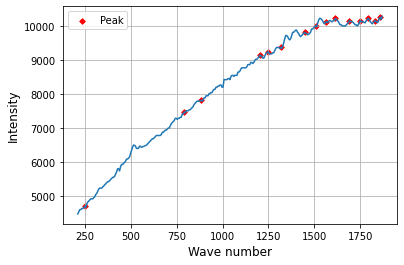

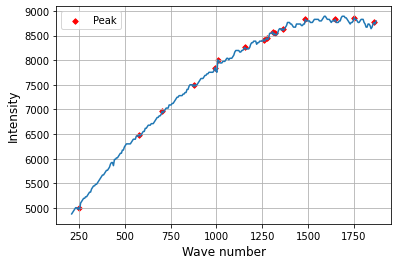

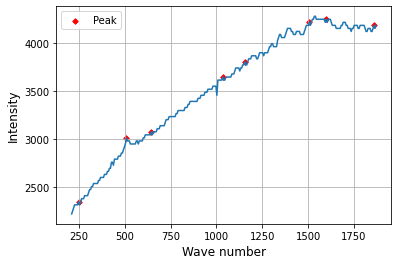

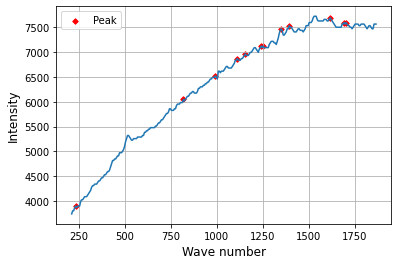

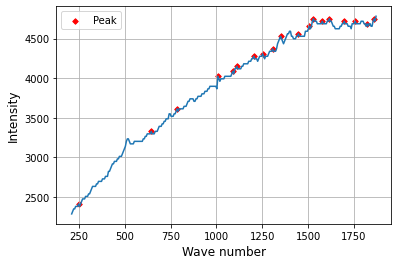

firstPointArrayPeaks:  [{'waveNumber': 249.32249322493226, 'intensity': 4687.747035573122}, {'waveNumber': 791.3279132791329, 'intensity': 7470.355731225296}, {'waveNumber': 883.4688346883469, 'intensity': 7818.181818181818}, {'waveNumber': 1203.2520325203252, 'intensity': 9146.245059288536}, {'waveNumber': 1246.6124661246613, 'intensity': 9241.106719367588}, {'waveNumber': 1317.0731707317073, 'intensity': 9367.588932806324}, {'waveNumber': 1447.1544715447155, 'intensity': 9810.276679841896}, {'waveNumber': 1506.7750677506776, 'intensity': 10000.0}, {'waveNumber': 1566.3956639566395, 'intensity': 10126.482213438736}, {'waveNumber': 1615.1761517615178, 'intensity': 10221.343873517786}, {'waveNumber': 1691.0569105691056, 'intensity': 10158.10276679842}, {'waveNumber': 1750.6775067750677, 'intensity': 10158.10276679842}, {'waveNumber': 1794.0379403794038, 'intensity': 10221.343873517786}, {'waveNumber': 1831.978319783198, 'intensity': 10158.10276679842}, {'waveNumber': 1859.0785907859079,

In [72]:
row = getResultsFromImg("img/samples/12.bmp", 12, row + 3)

axisYCoords:  [{'x': 91, 'y': 43}, {'x': 91, 'y': 44}, {'x': 91, 'y': 45}, {'x': 91, 'y': 46}, {'x': 91, 'y': 47}, {'x': 91, 'y': 48}, {'x': 91, 'y': 49}, {'x': 91, 'y': 50}, {'x': 91, 'y': 51}, {'x': 91, 'y': 52}, {'x': 91, 'y': 53}, {'x': 91, 'y': 54}, {'x': 91, 'y': 55}, {'x': 91, 'y': 56}, {'x': 91, 'y': 57}, {'x': 91, 'y': 58}, {'x': 91, 'y': 59}, {'x': 91, 'y': 60}, {'x': 91, 'y': 61}, {'x': 91, 'y': 62}, {'x': 91, 'y': 63}, {'x': 91, 'y': 64}, {'x': 91, 'y': 65}, {'x': 91, 'y': 66}, {'x': 91, 'y': 67}, {'x': 91, 'y': 68}, {'x': 91, 'y': 69}, {'x': 91, 'y': 70}, {'x': 91, 'y': 71}, {'x': 91, 'y': 72}, {'x': 91, 'y': 73}, {'x': 91, 'y': 74}, {'x': 91, 'y': 75}, {'x': 91, 'y': 76}, {'x': 91, 'y': 77}, {'x': 91, 'y': 78}, {'x': 91, 'y': 79}, {'x': 91, 'y': 80}, {'x': 91, 'y': 81}, {'x': 91, 'y': 82}, {'x': 91, 'y': 83}, {'x': 91, 'y': 84}, {'x': 91, 'y': 85}, {'x': 91, 'y': 86}, {'x': 91, 'y': 87}, {'x': 91, 'y': 88}, {'x': 91, 'y': 89}, {'x': 91, 'y': 90}, {'x': 91, 'y': 91}, {'x':

firstBigStrokeX:  {'x': 91, 'y': 321} lastBigStrokeX:  {'x': 453, 'y': 321}
firstBigStrokeY:  {'x': 91, 'y': 305} lastBigStrokeY:  {'x': 91, 'y': 58}
secondSmallStrokeX:  {'x': 435, 'y': 321}
maxValueY:  5000
maxValueX:  2000
minValueY:  1000
minValueX:  0
img_1px_equel_func_valueX:  5.524861878453039
img_1px_equel_func_valueY:  16.194331983805668
firstPointArray:  [{'x': 38, 'y': 304.0}, {'x': 39, 'y': 304.0}, {'x': 40, 'y': 303.0}, {'x': 41, 'y': 303.0}, {'x': 42, 'y': 303.0}, {'x': 43, 'y': 302.0}, {'x': 44, 'y': 302.0}, {'x': 45, 'y': 303.0}, {'x': 46, 'y': 302.0}, {'x': 47, 'y': 303.0}, {'x': 48, 'y': 302.0}, {'x': 49, 'y': 301.0}, {'x': 50, 'y': 301.0}, {'x': 51, 'y': 300.0}, {'x': 52, 'y': 300.0}, {'x': 53, 'y': 301.0}, {'x': 54, 'y': 300.0}, {'x': 55, 'y': 300.0}, {'x': 56, 'y': 300.0}, {'x': 57, 'y': 299.0}, {'x': 58, 'y': 298.0}, {'x': 59, 'y': 298.0}, {'x': 60, 'y': 298.0}, {'x': 61, 'y': 298.0}, {'x': 62, 'y': 297.0}, {'x': 63, 'y': 297.0}, {'x': 64, 'y': 297.0}, {'x': 65, 

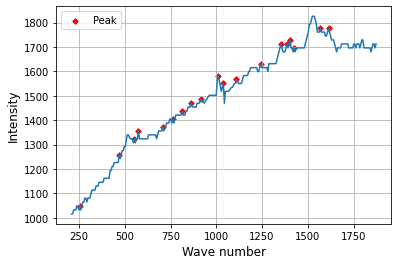

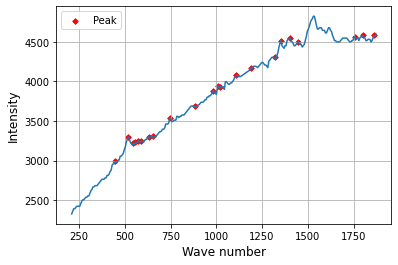

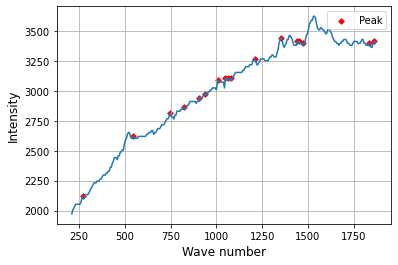

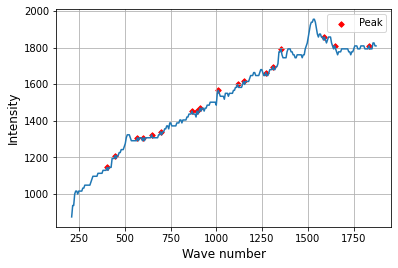

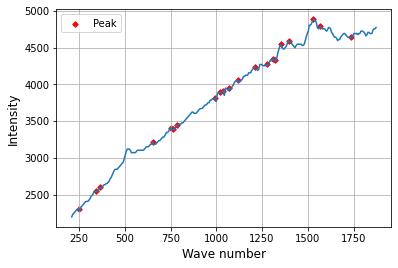

firstPointArrayPeaks:  [{'waveNumber': 254.14364640883977, 'intensity': 1048.582995951417}, {'waveNumber': 469.6132596685083, 'intensity': 1259.1093117408907}, {'waveNumber': 552.4861878453039, 'intensity': 1323.8866396761134}, {'waveNumber': 574.585635359116, 'intensity': 1356.2753036437248}, {'waveNumber': 707.182320441989, 'intensity': 1372.4696356275304}, {'waveNumber': 762.4309392265194, 'intensity': 1404.8582995951417}, {'waveNumber': 812.1546961325967, 'intensity': 1437.246963562753}, {'waveNumber': 861.878453038674, 'intensity': 1469.6356275303644}, {'waveNumber': 917.1270718232045, 'intensity': 1485.82995951417}, {'waveNumber': 1011.0497237569061, 'intensity': 1582.995951417004}, {'waveNumber': 1038.6740331491712, 'intensity': 1550.6072874493927}, {'waveNumber': 1110.4972375690609, 'intensity': 1566.8016194331985}, {'waveNumber': 1243.0939226519338, 'intensity': 1631.578947368421}, {'waveNumber': 1353.5911602209944, 'intensity': 1712.5506072874493}, {'waveNumber': 1386.7403314

In [73]:
row = getResultsFromImg("img/samples/13.bmp", 13, row + 3)

axisYCoords:  [{'x': 79, 'y': 44}, {'x': 79, 'y': 45}, {'x': 79, 'y': 46}, {'x': 79, 'y': 47}, {'x': 79, 'y': 48}, {'x': 79, 'y': 49}, {'x': 79, 'y': 50}, {'x': 79, 'y': 51}, {'x': 79, 'y': 52}, {'x': 79, 'y': 53}, {'x': 79, 'y': 54}, {'x': 79, 'y': 55}, {'x': 79, 'y': 56}, {'x': 79, 'y': 57}, {'x': 79, 'y': 58}, {'x': 79, 'y': 59}, {'x': 79, 'y': 60}, {'x': 79, 'y': 61}, {'x': 79, 'y': 62}, {'x': 79, 'y': 63}, {'x': 79, 'y': 64}, {'x': 79, 'y': 65}, {'x': 79, 'y': 66}, {'x': 79, 'y': 67}, {'x': 79, 'y': 68}, {'x': 79, 'y': 69}, {'x': 79, 'y': 70}, {'x': 79, 'y': 71}, {'x': 79, 'y': 72}, {'x': 79, 'y': 73}, {'x': 79, 'y': 74}, {'x': 79, 'y': 75}, {'x': 79, 'y': 76}, {'x': 79, 'y': 77}, {'x': 79, 'y': 78}, {'x': 79, 'y': 79}, {'x': 79, 'y': 80}, {'x': 79, 'y': 81}, {'x': 79, 'y': 82}, {'x': 79, 'y': 83}, {'x': 79, 'y': 84}, {'x': 79, 'y': 85}, {'x': 79, 'y': 86}, {'x': 79, 'y': 87}, {'x': 79, 'y': 88}, {'x': 79, 'y': 89}, {'x': 79, 'y': 90}, {'x': 79, 'y': 91}, {'x': 79, 'y': 92}, {'x':

firstBigStrokeX:  {'x': 79, 'y': 321} lastBigStrokeX:  {'x': 439, 'y': 321}
firstBigStrokeY:  {'x': 79, 'y': 299} lastBigStrokeY:  {'x': 79, 'y': 86}
secondSmallStrokeX:  {'x': 421, 'y': 321}
maxValueY:  6000
maxValueX:  2000
minValueY:  1000
minValueX:  0
img_1px_equel_func_valueX:  5.555555555555555
img_1px_equel_func_valueY:  23.474178403755868
firstPointArray:  [{'x': 38, 'y': 239.0}, {'x': 39, 'y': 239.0}, {'x': 40, 'y': 237.0}, {'x': 41, 'y': 237.0}, {'x': 42, 'y': 235.0}, {'x': 43, 'y': 235.0}, {'x': 44, 'y': 234.0}, {'x': 45, 'y': 233.0}, {'x': 46, 'y': 235.0}, {'x': 47, 'y': 233.0}, {'x': 48, 'y': 231.0}, {'x': 49, 'y': 230.0}, {'x': 50, 'y': 229.0}, {'x': 51, 'y': 229.0}, {'x': 52, 'y': 228.0}, {'x': 53, 'y': 228.0}, {'x': 54, 'y': 228.0}, {'x': 55, 'y': 227.0}, {'x': 56, 'y': 226.0}, {'x': 57, 'y': 223.0}, {'x': 58, 'y': 223.0}, {'x': 59, 'y': 222.0}, {'x': 60, 'y': 221.0}, {'x': 61, 'y': 221.0}, {'x': 62, 'y': 220.0}, {'x': 63, 'y': 220.0}, {'x': 64, 'y': 219.0}, {'x': 65, 

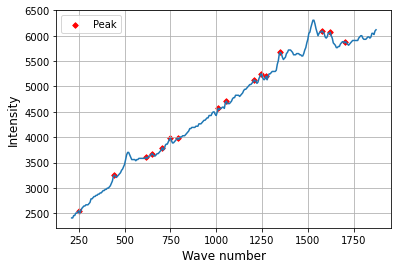

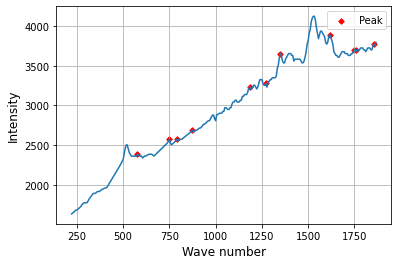

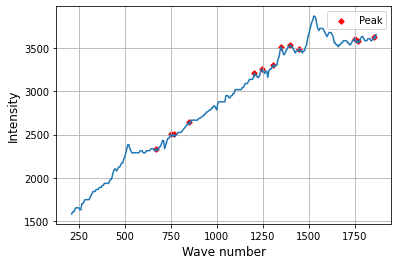

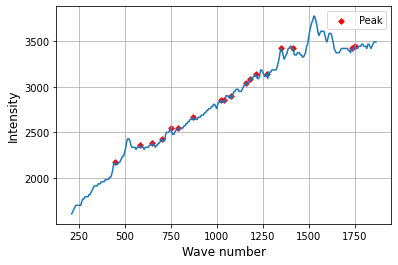

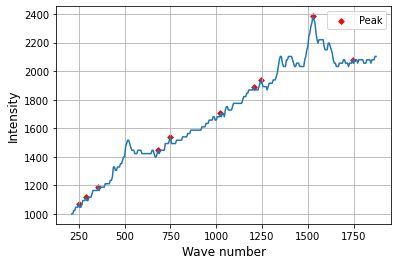

firstPointArrayPeaks:  [{'waveNumber': 250.0, 'intensity': 2549.2957746478874}, {'waveNumber': 444.44444444444446, 'intensity': 3253.521126760563}, {'waveNumber': 616.6666666666666, 'intensity': 3605.633802816901}, {'waveNumber': 650.0, 'intensity': 3676.0563380281687}, {'waveNumber': 705.5555555555555, 'intensity': 3793.4272300469484}, {'waveNumber': 750.0, 'intensity': 3981.220657276995}, {'waveNumber': 788.8888888888889, 'intensity': 3981.220657276995}, {'waveNumber': 1011.1111111111111, 'intensity': 4568.075117370892}, {'waveNumber': 1055.5555555555554, 'intensity': 4708.9201877934265}, {'waveNumber': 1205.5555555555554, 'intensity': 5131.455399061033}, {'waveNumber': 1244.4444444444443, 'intensity': 5248.826291079812}, {'waveNumber': 1272.2222222222222, 'intensity': 5201.8779342723}, {'waveNumber': 1350.0, 'intensity': 5671.361502347418}, {'waveNumber': 1577.7777777777778, 'intensity': 6093.896713615023}, {'waveNumber': 1622.2222222222222, 'intensity': 6070.422535211267}, {'waveNu

In [74]:
row = getResultsFromImg("img/samples/14.bmp", 14, row + 3)

axisYCoords:  [{'x': 105, 'y': 62}, {'x': 105, 'y': 63}, {'x': 105, 'y': 64}, {'x': 105, 'y': 65}, {'x': 105, 'y': 66}, {'x': 105, 'y': 67}, {'x': 105, 'y': 68}, {'x': 105, 'y': 69}, {'x': 105, 'y': 70}, {'x': 105, 'y': 71}, {'x': 105, 'y': 72}, {'x': 105, 'y': 73}, {'x': 105, 'y': 74}, {'x': 105, 'y': 75}, {'x': 105, 'y': 76}, {'x': 105, 'y': 77}, {'x': 105, 'y': 78}, {'x': 105, 'y': 79}, {'x': 105, 'y': 80}, {'x': 105, 'y': 81}, {'x': 105, 'y': 82}, {'x': 105, 'y': 83}, {'x': 105, 'y': 84}, {'x': 105, 'y': 85}, {'x': 105, 'y': 86}, {'x': 105, 'y': 87}, {'x': 105, 'y': 88}, {'x': 105, 'y': 89}, {'x': 105, 'y': 90}, {'x': 105, 'y': 91}, {'x': 105, 'y': 92}, {'x': 105, 'y': 93}, {'x': 105, 'y': 94}, {'x': 105, 'y': 95}, {'x': 105, 'y': 96}, {'x': 105, 'y': 97}, {'x': 105, 'y': 98}, {'x': 105, 'y': 99}, {'x': 105, 'y': 100}, {'x': 105, 'y': 101}, {'x': 105, 'y': 102}, {'x': 105, 'y': 103}, {'x': 105, 'y': 104}, {'x': 105, 'y': 105}, {'x': 105, 'y': 106}, {'x': 105, 'y': 107}, {'x': 105, 

firstBigStrokeX:  {'x': 105, 'y': 341} lastBigStrokeX:  {'x': 466, 'y': 341}
firstBigStrokeY:  {'x': 105, 'y': 341} lastBigStrokeY:  {'x': 105, 'y': 80}
secondSmallStrokeX:  {'x': 448, 'y': 341}
maxValueY:  4000
maxValueX:  2000
minValueY:  500
minValueX:  0
img_1px_equel_func_valueX:  5.54016620498615
img_1px_equel_func_valueY:  13.409961685823754
firstPointArray:  [{'x': 38, 'y': 332.0}, {'x': 39, 'y': 332.0}, {'x': 40, 'y': 332.0}, {'x': 41, 'y': 331.0}, {'x': 42, 'y': 331.0}, {'x': 43, 'y': 331.0}, {'x': 44, 'y': 331.0}, {'x': 45, 'y': 331.0}, {'x': 46, 'y': 333.0}, {'x': 47, 'y': 332.0}, {'x': 48, 'y': 331.0}, {'x': 49, 'y': 330.0}, {'x': 50, 'y': 330.0}, {'x': 51, 'y': 330.0}, {'x': 52, 'y': 330.0}, {'x': 53, 'y': 330.0}, {'x': 54, 'y': 330.0}, {'x': 55, 'y': 330.0}, {'x': 56, 'y': 329.0}, {'x': 57, 'y': 330.0}, {'x': 58, 'y': 329.0}, {'x': 59, 'y': 329.0}, {'x': 60, 'y': 329.0}, {'x': 61, 'y': 329.0}, {'x': 62, 'y': 328.0}, {'x': 63, 'y': 328.0}, {'x': 64, 'y': 328.0}, {'x': 65,

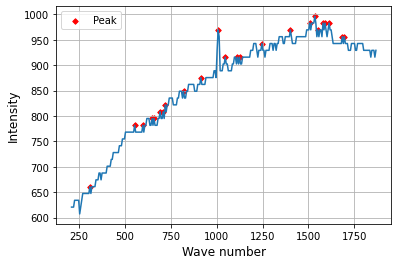

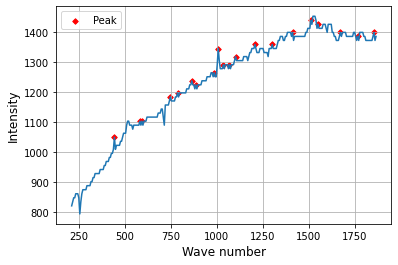

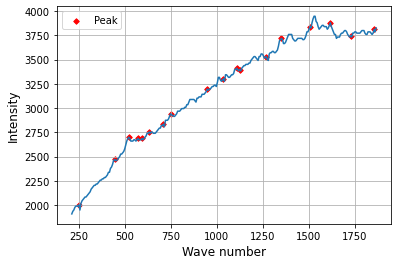

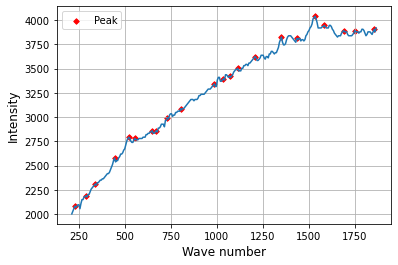

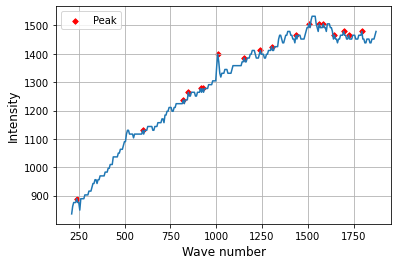

firstPointArrayPeaks:  [{'waveNumber': 310.2493074792244, 'intensity': 660.9195402298851}, {'waveNumber': 554.016620498615, 'intensity': 781.6091954022988}, {'waveNumber': 598.3379501385042, 'intensity': 781.6091954022988}, {'waveNumber': 648.1994459833795, 'intensity': 795.0191570881226}, {'waveNumber': 659.2797783933519, 'intensity': 795.0191570881226}, {'waveNumber': 692.5207756232687, 'intensity': 808.4291187739464}, {'waveNumber': 709.1412742382272, 'intensity': 808.4291187739464}, {'waveNumber': 720.2216066481994, 'intensity': 821.8390804597701}, {'waveNumber': 819.9445983379502, 'intensity': 848.6590038314176}, {'waveNumber': 914.1274238227147, 'intensity': 875.478927203065}, {'waveNumber': 1008.3102493074794, 'intensity': 969.3486590038315}, {'waveNumber': 1047.0914127423823, 'intensity': 915.7088122605364}, {'waveNumber': 1113.5734072022162, 'intensity': 915.7088122605364}, {'waveNumber': 1124.6537396121885, 'intensity': 915.7088122605364}, {'waveNumber': 1246.5373961218838, '

In [75]:
row = getResultsFromImg("img/samples/15.bmp", 15, row + 3)
wb.save('samples.xlsx')

In [39]:
wb = Workbook()
ws = wb.active

# обработка изображений и получение данных и сохранение в Excell
row = getResultsFromImg("img/samples/1.bmp", 1, 1)
row = getResultsFromImg("img/samples/2.bmp", 2, row + 3)
row = getResultsFromImg("img/samples/3.bmp", 3, row + 3)
row = getResultsFromImg("img/samples/4.bmp", 4, row + 3)
row = getResultsFromImg("img/samples/5.bmp", 5, row + 3)
row = getResultsFromImg("img/samples/6.bmp", 6, row + 3)
row = getResultsFromImg("img/samples/7.bmp", 7, row + 3)
row = getResultsFromImg("img/samples/8.bmp", 8, row + 3)
row = getResultsFromImg("img/samples/9.bmp", 9, row + 3)
row = getResultsFromImg("img/samples/10.bmp", 10, row + 3)
row = getResultsFromImg("img/samples/11.bmp", 11, row + 3)
row = getResultsFromImg("img/samples/12.bmp", 12, row + 3)
row = getResultsFromImg("img/samples/13.bmp", 13, row + 3)
row = getResultsFromImg("img/samples/14.bmp", 14, row + 3)
row = getResultsFromImg("img/samples/15.bmp", 15, row + 3)
wb.save('samples.xlsx')

[{'x': 6, 'y': 12}, {'x': 8, 'y': 10}]
